# IMPACT OF CITY ELEVATION ON AIR QUALITY

## Importing dependencies and setup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import datetime
from pprint import pprint
import plotly.express as px

## Importing datasets of air quality data

In [2]:
# Loop through historical air quality data csv files in the historical_data folder
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4","2015H1","2016H1","2017H1","2018H1"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
# Combine individual air quality dataframes into one
airdf_2015_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2015_2020.head()

Date Country     City       Specie  count   min   max  median  \
0  31/05/2020      IR  Isfahan  temperature    120  17.5  35.0    27.5   
1  13/06/2020      IR  Isfahan  temperature    144  16.0  36.5    27.5   
2   3/07/2020      IR  Isfahan  temperature     67  19.0  33.0    24.0   
3  28/03/2020      IR  Isfahan  temperature    240   3.0  14.0     9.5   
4  23/04/2020      IR  Isfahan  temperature    168   6.0  25.5    16.0   

   variance  
0    331.51  
1    488.74  
2    128.08  
3    136.68  
4    400.79

## Slicing and dicing the data

In [5]:
# Display an overview of the Specie column
airdf_2015_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1', 'psi', 'd'], dtype=object)

In [6]:
# Display an overview of the number of rows each Specie has in the dataframe
airdf_2015_2020["Specie"].value_counts()

Specie
no2              569961
pm25             555518
pm10             553043
o3               545177
so2              474172
co               430596
temperature      334029
humidity         333932
pressure         331959
wind-speed       283664
dew              226147
wind-gust        187664
wind speed        47002
wd                29914
wind gust         29576
precipitation     28659
aqi               19568
uvi               14153
pol                4958
d                  2031
pm1                1756
neph               1553
mepaqi             1307
psi                 363
Name: count, dtype: int64

> Since we are focussing on air quality related to human activity and its correlation with elevation of a city we are focussing on 6 qualities of air quality and identify main source for these to be present in the atmosphere

    1. no2: combustion of fossil fuels (coal, gas and oil) especially fuel used in cars
    2. pm25: particles which are directly emitted into the atmosphere can originate from both natural sources, such as dust storms and forest fires, and anthropogenic sources, such as fossil fuel combustion, cigarette smoke, and biomass burning.
    3. pm10: also includes dust from construction sites, landfills and agriculture, wildfires and brush/waste burning, industrial sources, wind-blown dust from open lands, pollen and fragments of bacteria.
    4. o3: when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight
    5. so2: sulfur dioxide released into the environment comes from electric utilities, especially those that burn coal. Some other sources of sulfur dioxide include petroleum refineries, cement manufacturing, paper pulp manufacturing, and metal smelting and processing facilities.
    6. co: results from the incomplete combustion of carbon-containing fuels such as natural gas, gasoline, or wood, and is emitted by a wide variety of combustion sources, including motor vehicles, power plants, wildfires, and incinerators.
    
    Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**. We'll also remove species with the least number of available data points  including **aqi, pol, pm1, mepaqi, neph,d, psi**.

In [13]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "aqi", "uvi", "pol", "pm1", "mepaqi", "neph","d", "psi"]

short_airdf = airdf_2015_2020[~airdf_2015_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [14]:
short_airdf.head()

Date Country     City Specie  count   min    max  median  variance
0  24/02/2020      IR  Isfahan   pm25    129  54.0  194.0   126.0  10921.40
1   7/05/2020      IR  Isfahan   pm25    168  17.0  168.0    91.0  14014.00
2  28/05/2020      IR  Isfahan   pm25    127  17.0  115.0    72.0   3558.56
3  20/02/2020      IR  Isfahan   pm25    113  26.0  181.0    76.0  11209.80
4  23/02/2020      IR  Isfahan   pm25    132  22.0  132.0    76.0   3209.67

In [15]:
# Overview of the remaining air pollutant species in focus
short_airdf["Specie"].value_counts()

Specie
no2     569961
pm25    555518
pm10    553043
o3      545177
so2     474172
co      430596
Name: count, dtype: int64

> More details about the sources of the above major outdoor air pollutants can be referred to [source_outdoor_air_pollutants](https://learn.kaiterra.com/en/air-academy/5-major-outdoor-air-pollutants).

In [16]:
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128467 entries, 0 to 3128466
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Date      object 
 1   Country   object 
 2   City      object 
 3   Specie    object 
 4   count     int64  
 5   min       float64
 6   max       float64
 7   median    float64
 8   variance  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 214.8+ MB


>Date column is of generic object type. Use to_datetime() function to convert the Date column into a datetime object. 

In [18]:
short_airdf["Date"] = pd.to_datetime(short_airdf["Date"], format="%d/%m/%Y")

In [19]:
# Double check the Date data type
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128467 entries, 0 to 3128466
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Country   object        
 2   City      object        
 3   Specie    object        
 4   count     int64         
 5   min       float64       
 6   max       float64       
 7   median    float64       
 8   variance  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 214.8+ MB


In [20]:
# Find the earliest date the air quality dataset covers:
short_airdf["Date"].min()

Timestamp('2014-12-29 00:00:00')

In [21]:
# Find the latest date the air quality dataset covers:
short_airdf["Date"].max()

Timestamp('2020-07-03 00:00:00')

In [22]:
# We will look at 24 month data as a starting point. Thus limitng our data from 1st Jun 2018 to 31st May 2020 
clean_airdf = short_airdf[(short_airdf["Date"] >= pd.to_datetime(
    "2018-06-01")) & (short_airdf["Date"] <= pd.to_datetime("2020-05-31"))].copy()

clean_airdf.head()

Date Country     City Specie  count   min    max  median  variance
0 2020-02-24      IR  Isfahan   pm25    129  54.0  194.0   126.0  10921.40
1 2020-05-07      IR  Isfahan   pm25    168  17.0  168.0    91.0  14014.00
2 2020-05-28      IR  Isfahan   pm25    127  17.0  115.0    72.0   3558.56
3 2020-02-20      IR  Isfahan   pm25    113  26.0  181.0    76.0  11209.80
4 2020-02-23      IR  Isfahan   pm25    132  22.0  132.0    76.0   3209.67

In [23]:
# Set the starting date for the air quality analysis
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2018-06-01 00:00:00')

In [24]:
# Set the cutoff date for the air quality analysis
end_date = clean_airdf["Date"].max()
end_date

Timestamp('2020-05-31 00:00:00')

In [26]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'NL', 'NZ', 'UG', 'VN', 'ET',
       'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR', 'IN',
       'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [27]:
clean_airdf["Country"].nunique()

94

> There are 94 countries in the air quality data.

In [28]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [29]:
clean_airdf["City"].nunique()

602

> There are 602 cities in the air data. 

In [30]:
clean_airdf.head()

Date Country     City Specie  count   min    max  median  variance
0 2020-02-24      IR  Isfahan   pm25    129  54.0  194.0   126.0  10921.40
1 2020-05-07      IR  Isfahan   pm25    168  17.0  168.0    91.0  14014.00
2 2020-05-28      IR  Isfahan   pm25    127  17.0  115.0    72.0   3558.56
3 2020-02-20      IR  Isfahan   pm25    113  26.0  181.0    76.0  11209.80
4 2020-02-23      IR  Isfahan   pm25    132  22.0  132.0    76.0   3209.67

In [31]:
# Transpose the clean_airdf so that the species will become the columns.
clean_airdf_transposed = clean_airdf.pivot_table(
    index=["Date", "Country", "City"], columns="Specie", values="median").copy()
clean_airdf_transposed.reset_index(inplace=True)

In [32]:
clean_airdf_transposed.head()

Specie       Date Country          City   co   no2    o3   pm10   pm25   so2
0      2018-06-01      AE     Abu Dhabi  0.1  15.1  37.4  102.0  165.0  13.7
1      2018-06-01      AE         Dubai  NaN   NaN   NaN    NaN  172.0   NaN
2      2018-06-01      AR  Buenos Aires  3.5   6.9   9.0   16.0   34.0   3.1
3      2018-06-01      AT          Graz  0.1   8.0   NaN   21.0    NaN   1.1
4      2018-06-01      AT     Innsbruck  0.1  11.7   NaN   14.0    NaN   0.6

In [33]:
# Create a new column that captures month of each year
clean_airdf_transposed['year_month'] = clean_airdf_transposed["Date"].dt.to_period("M")
clean_airdf_transposed.head()

Specie       Date Country          City   co   no2    o3   pm10   pm25   so2  \
0      2018-06-01      AE     Abu Dhabi  0.1  15.1  37.4  102.0  165.0  13.7   
1      2018-06-01      AE         Dubai  NaN   NaN   NaN    NaN  172.0   NaN   
2      2018-06-01      AR  Buenos Aires  3.5   6.9   9.0   16.0   34.0   3.1   
3      2018-06-01      AT          Graz  0.1   8.0   NaN   21.0    NaN   1.1   
4      2018-06-01      AT     Innsbruck  0.1  11.7   NaN   14.0    NaN   0.6   

Specie year_month  
0         2018-06  
1         2018-06  
2         2018-06  
3         2018-06  
4         2018-06

In [51]:
# Define a function to draw boxplots showing monthly distribution of median values of different air pollutants across 2019 and 2020H1
def specie_boxplot(specie):
    fig, ax = plt.subplots(figsize=(18, 24))

    red_diamond = dict(markerfacecolor='r', marker='D', alpha=0.3)
    sns.boxplot(data=clean_airdf_transposed, x='year_month',
                y=specie, flierprops=red_diamond)

    plt.xlabel("Year_Month", fontsize=16)
    plt.ylabel(specie, fontsize=16)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.title(
        f"Monthly Distribution of Median {specie} in 94 countries between ({starting_date} and {end_date}), 24 month period", fontsize=12)
    plt.savefig(f"images/boxplot_{specie}.png")

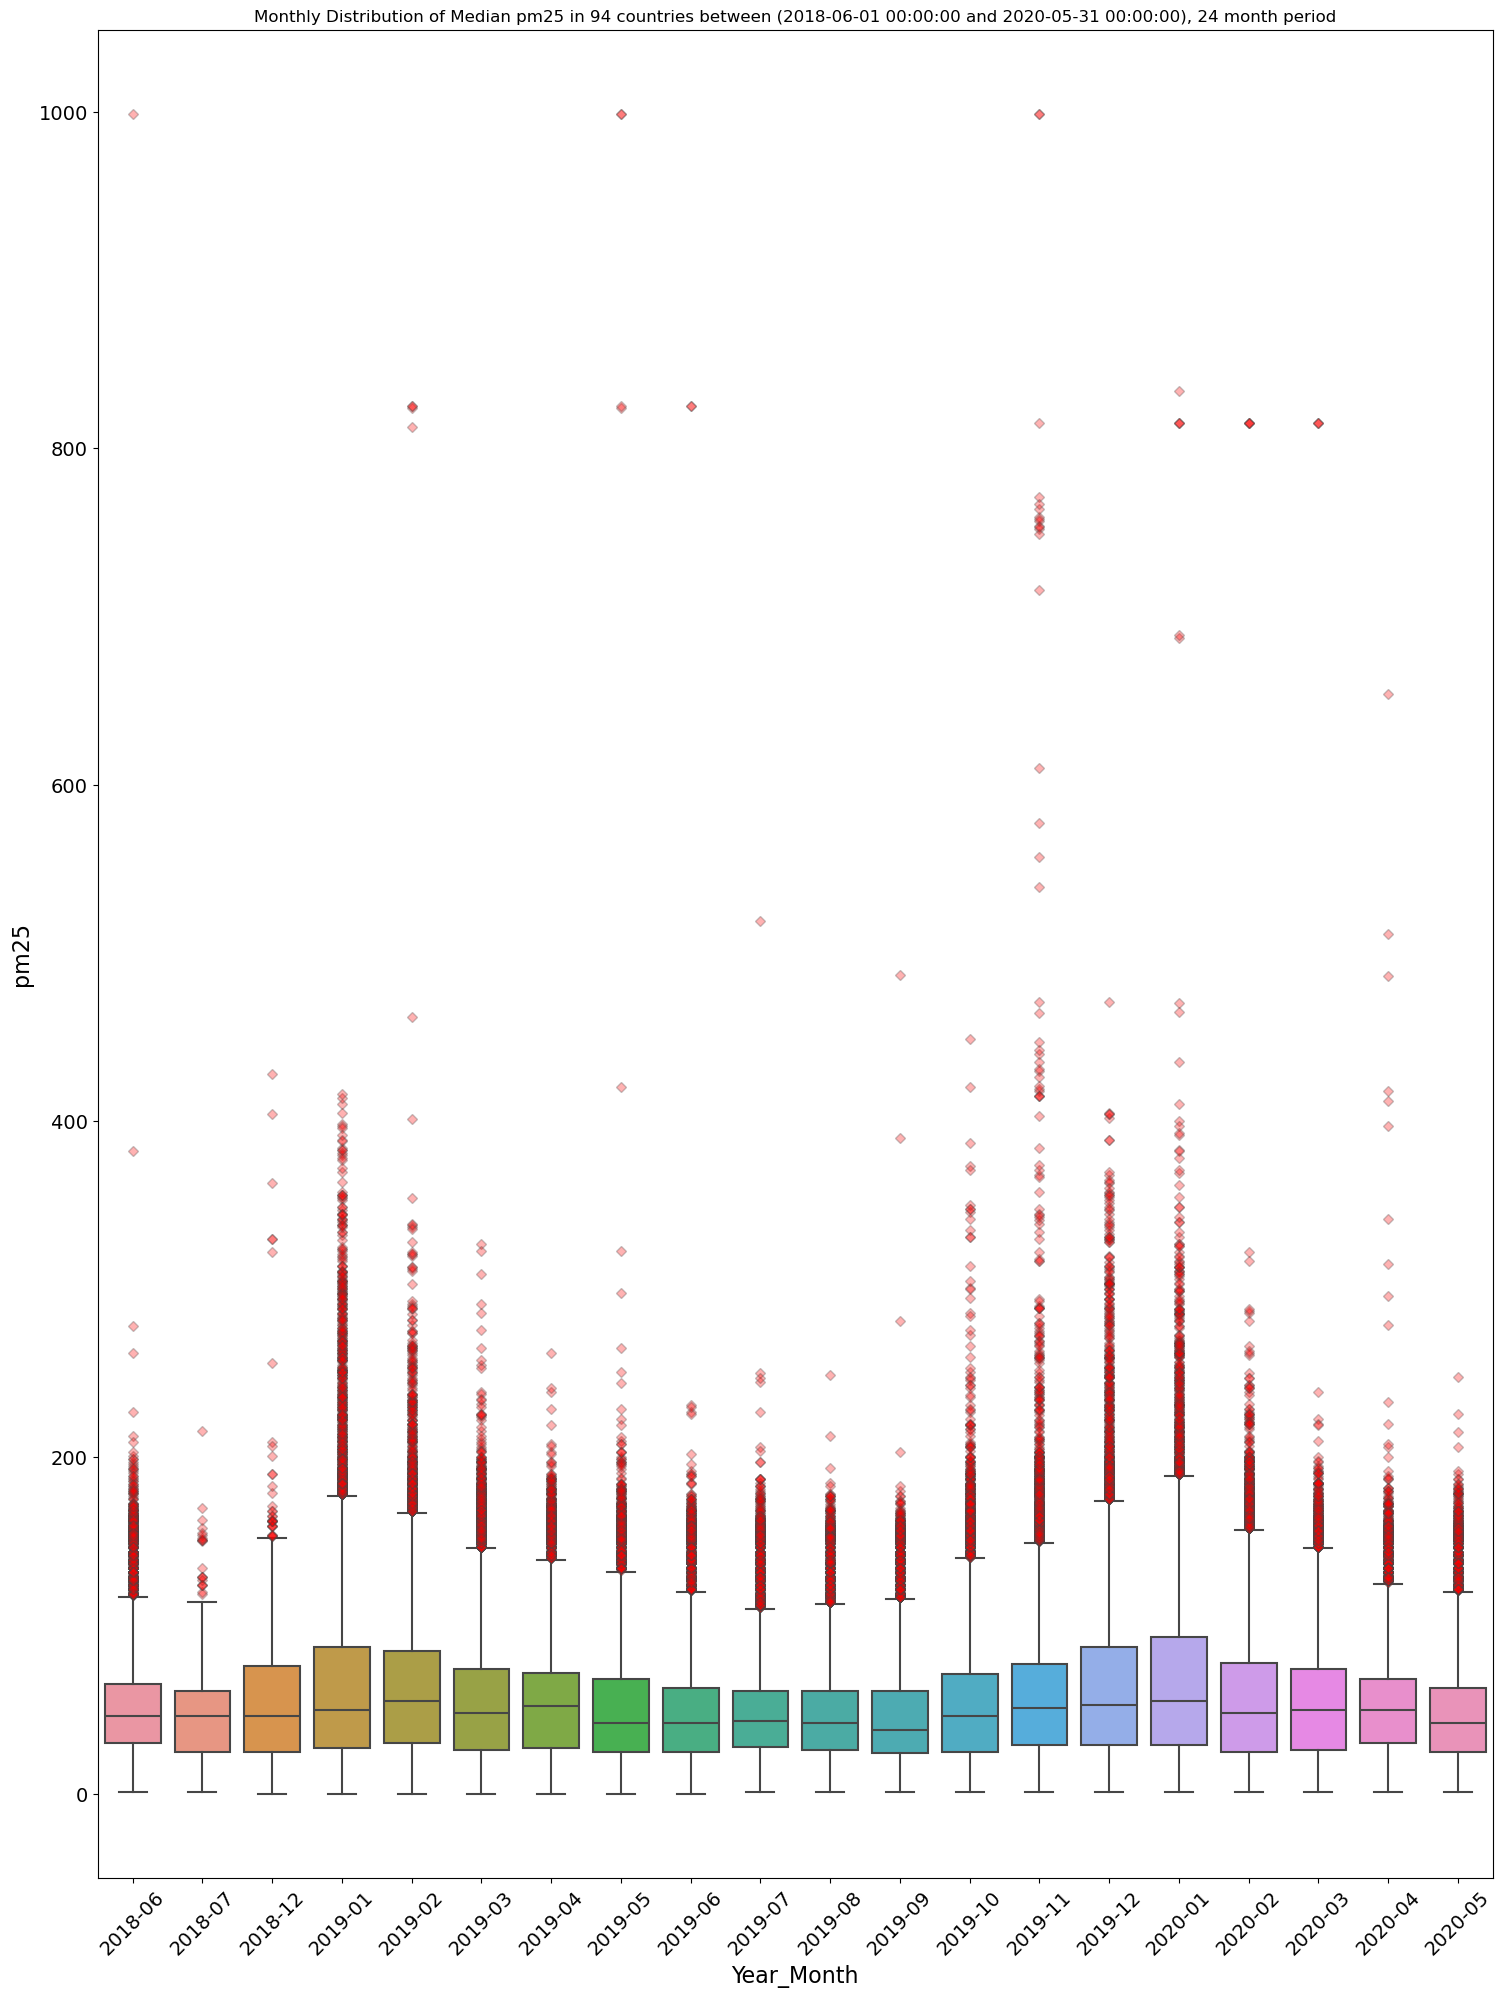

In [52]:
specie_boxplot("pm25")

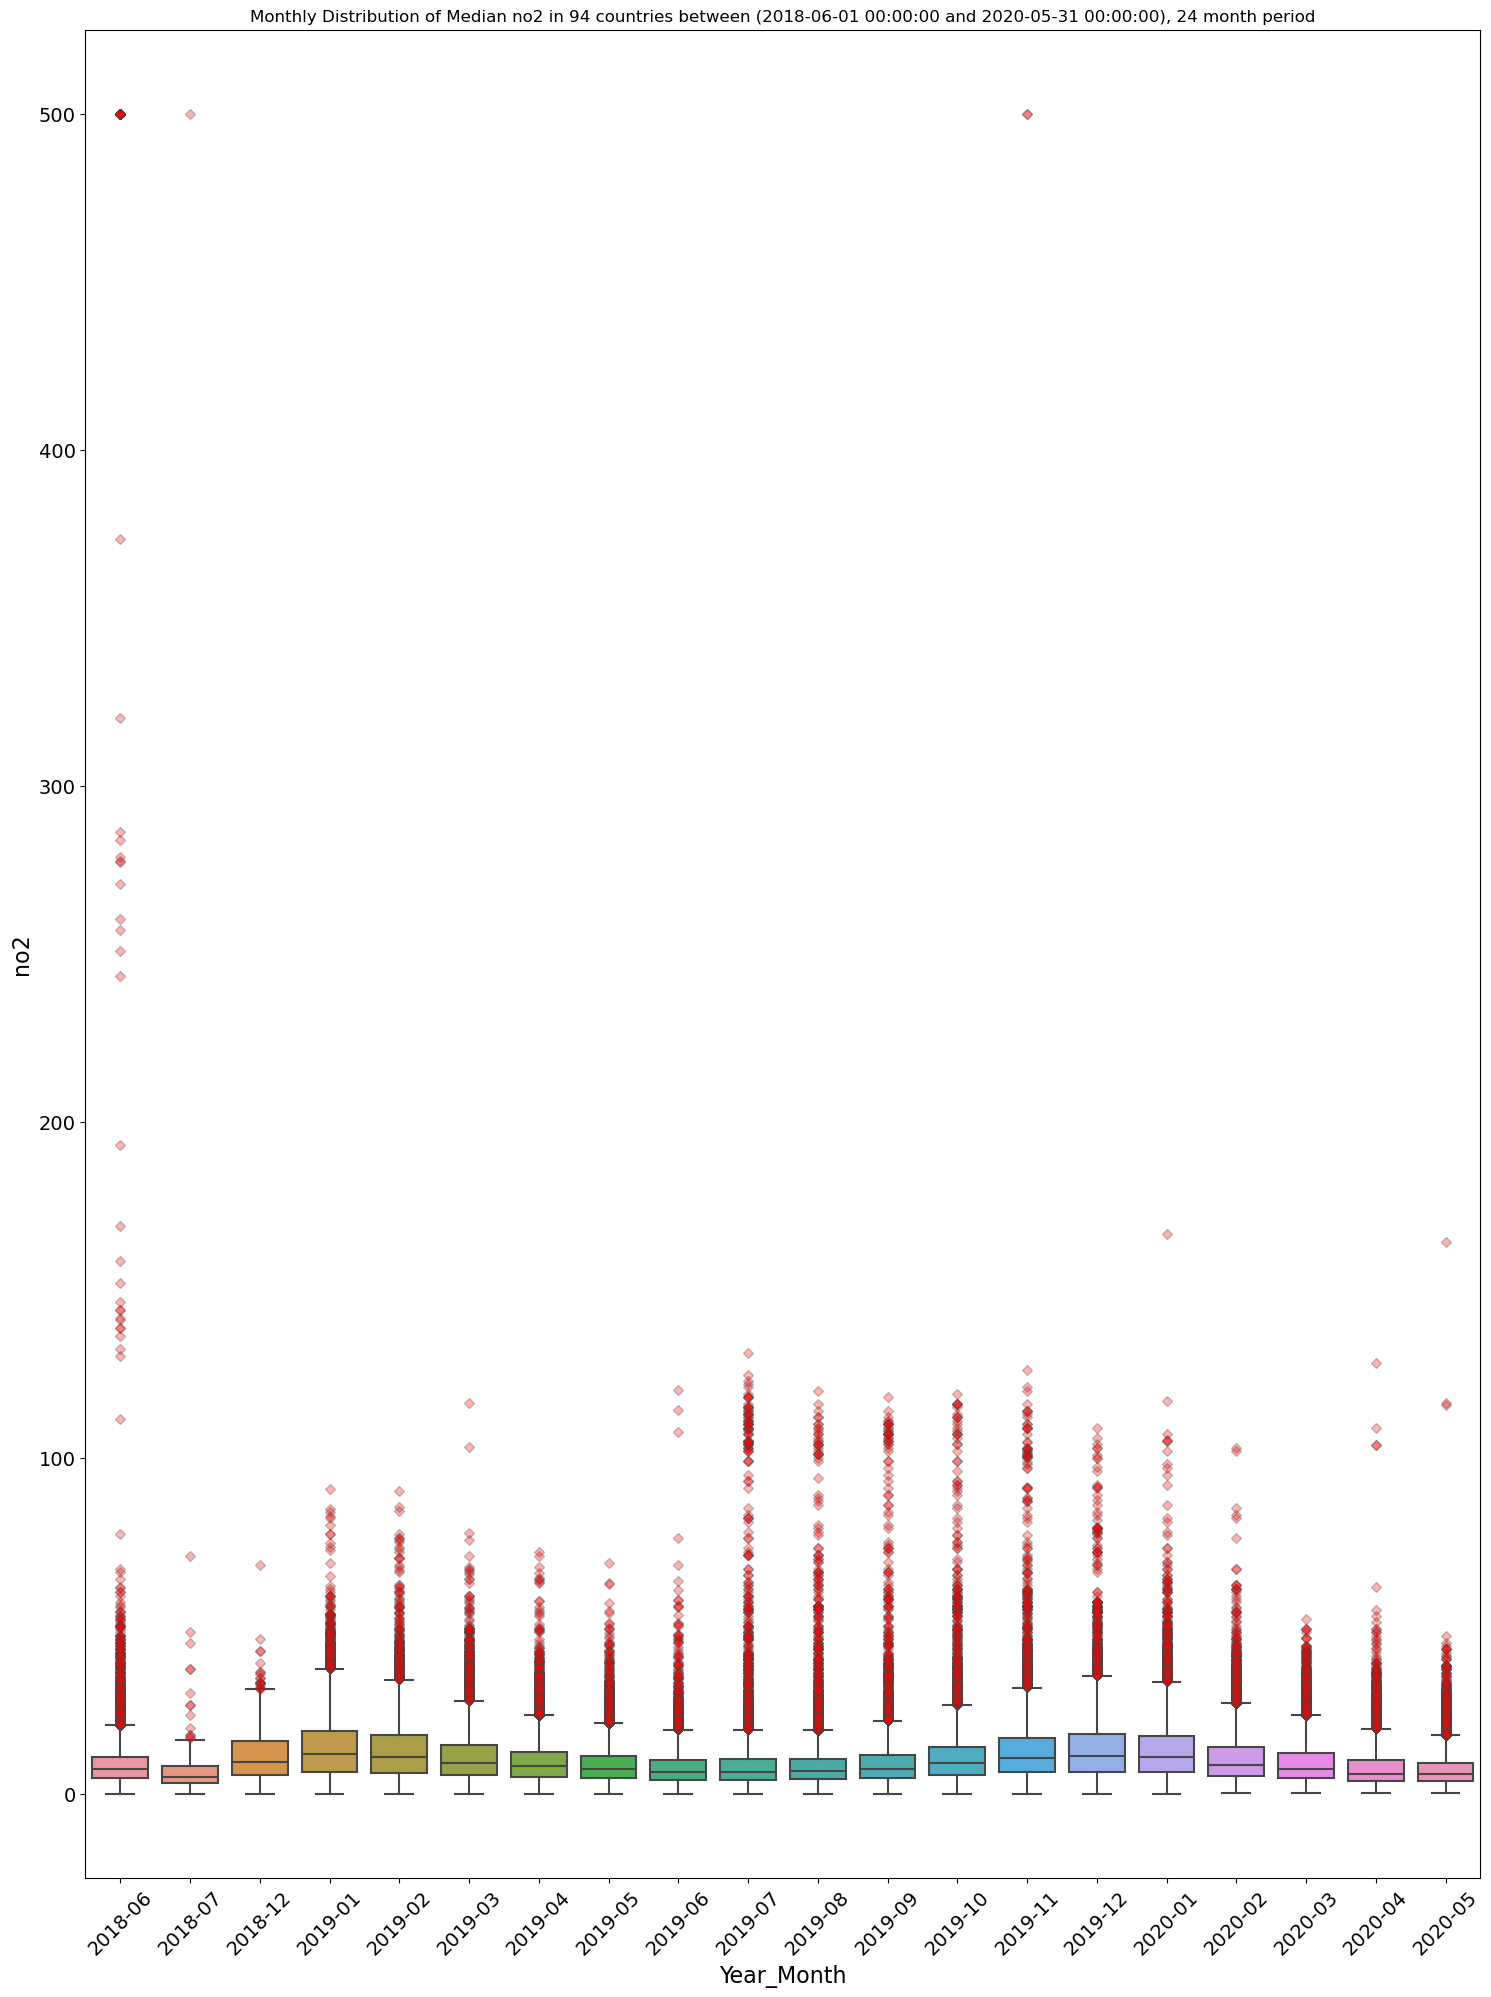

In [53]:
specie_boxplot("no2")

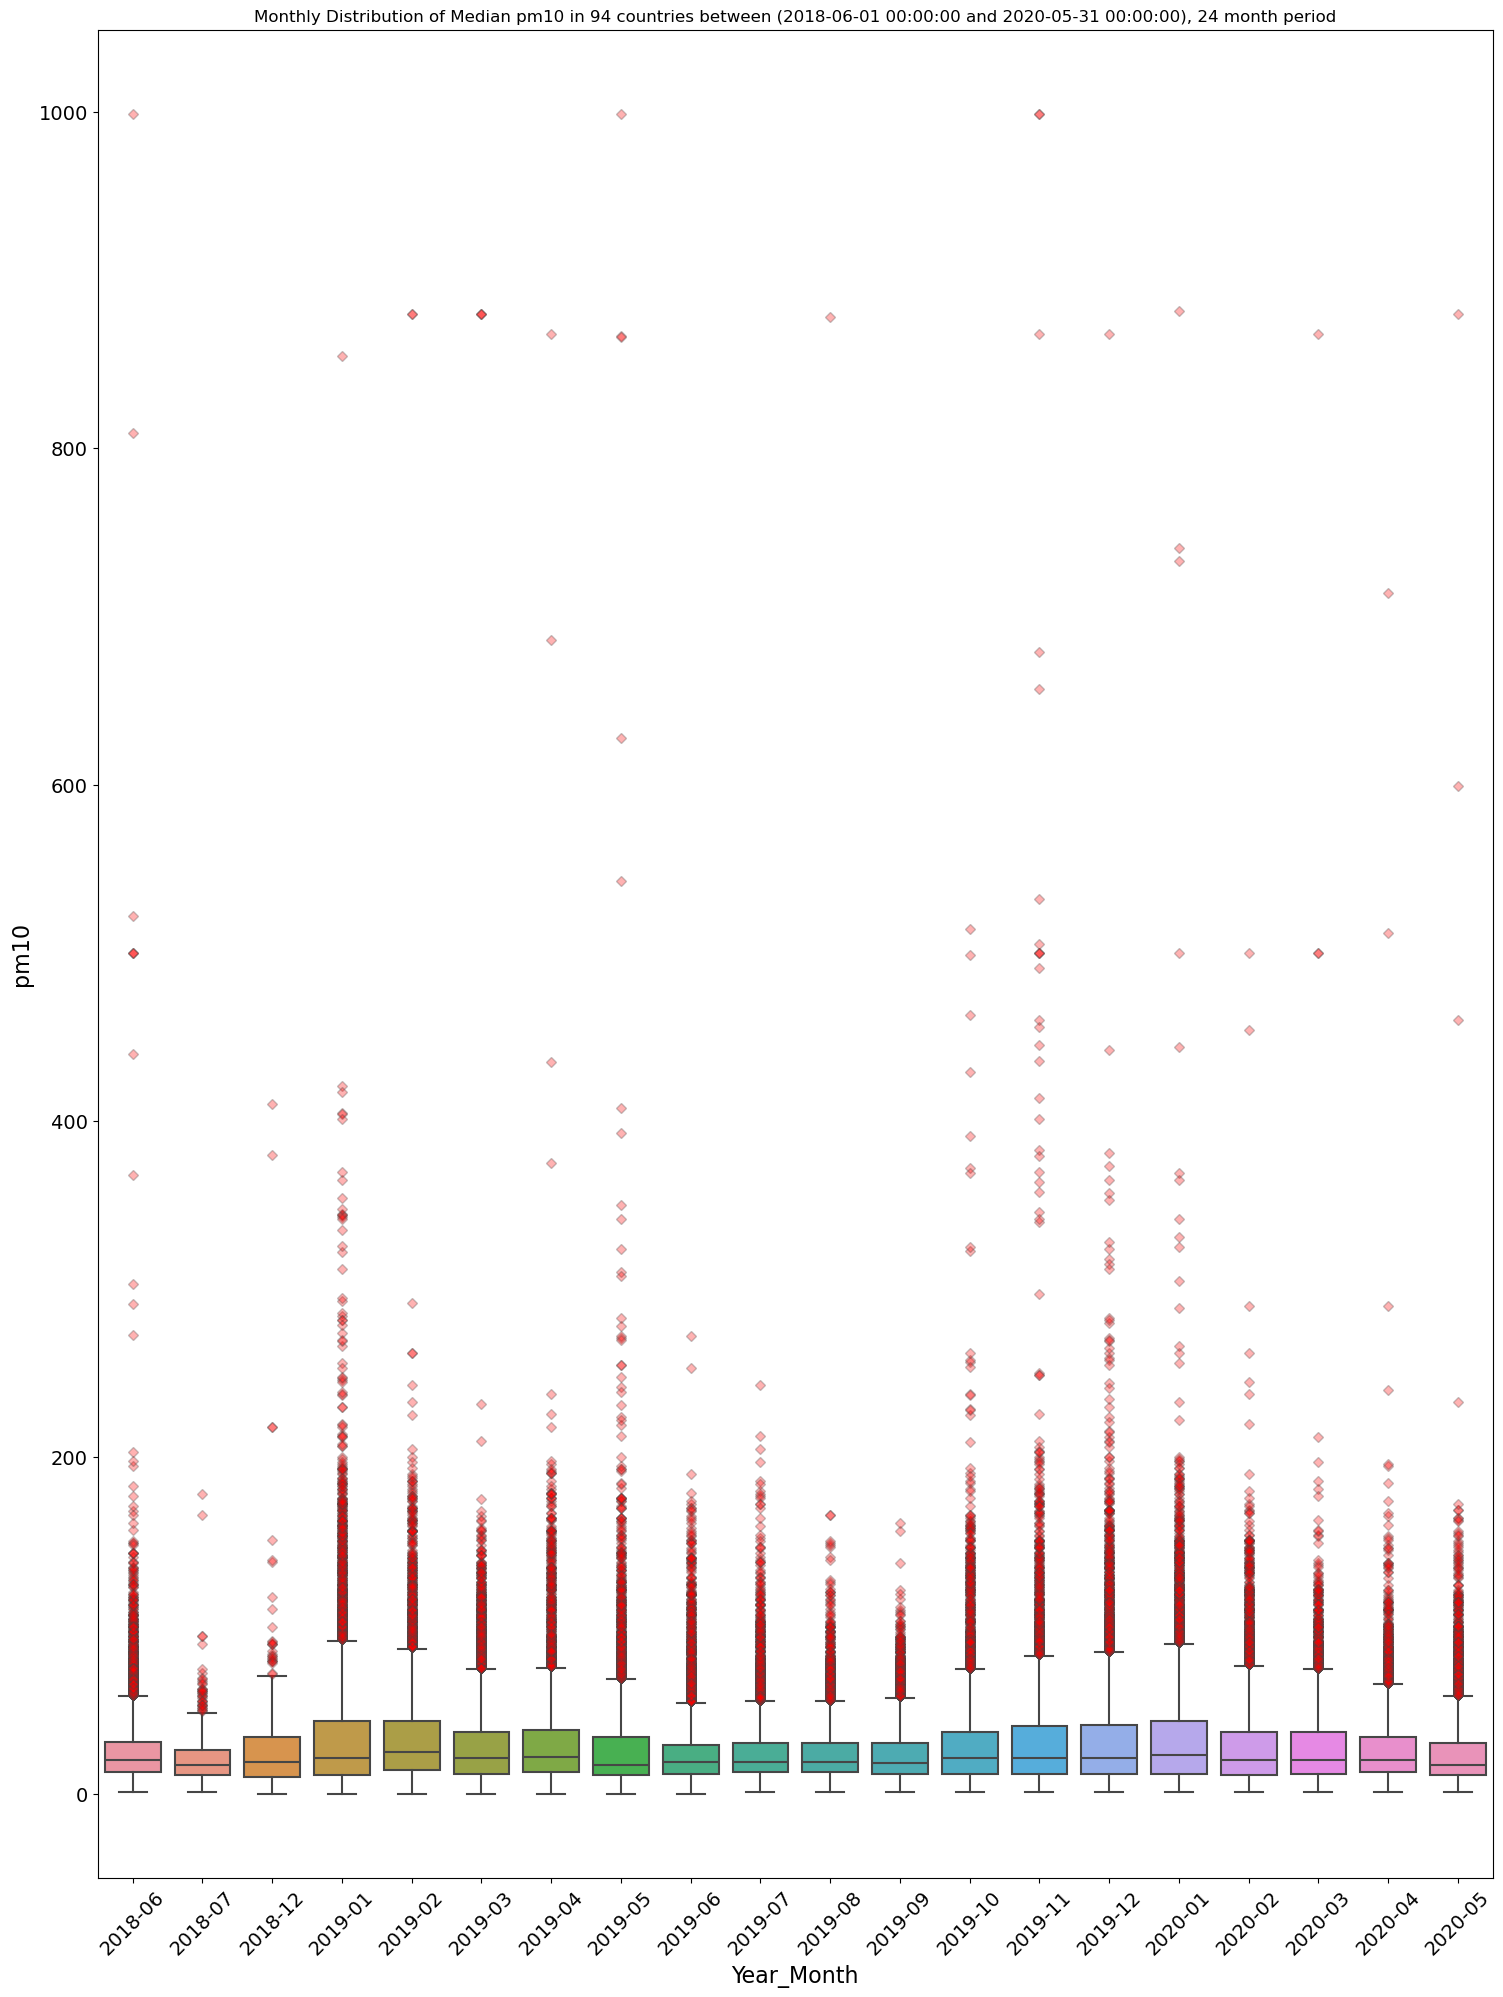

In [54]:
specie_boxplot("pm10")

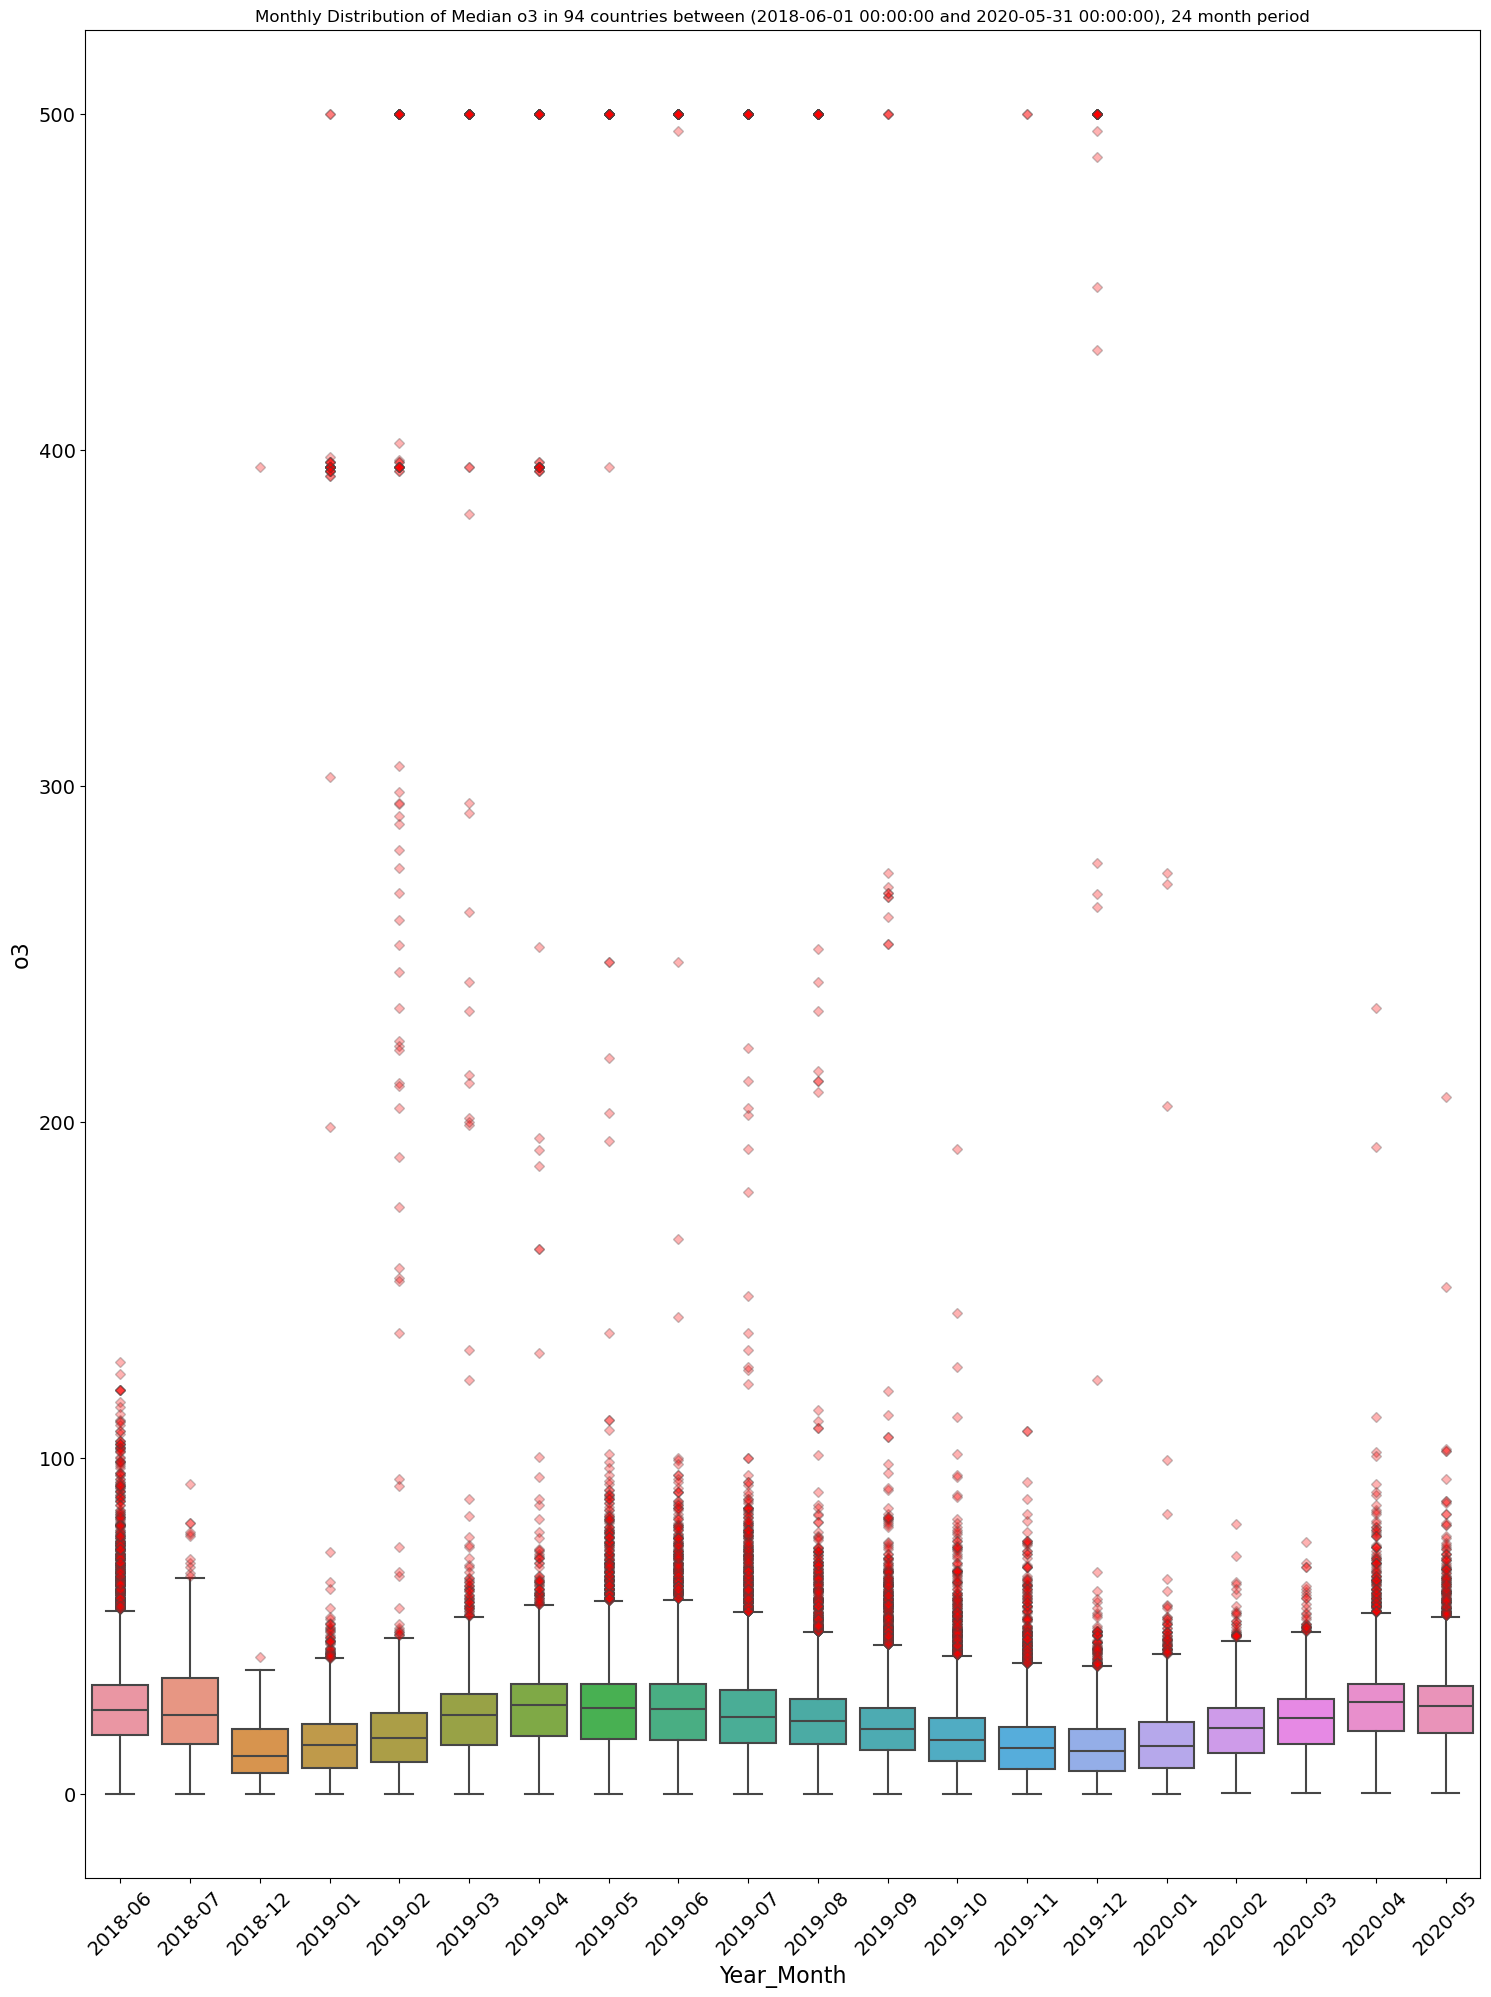

In [55]:
specie_boxplot("o3")

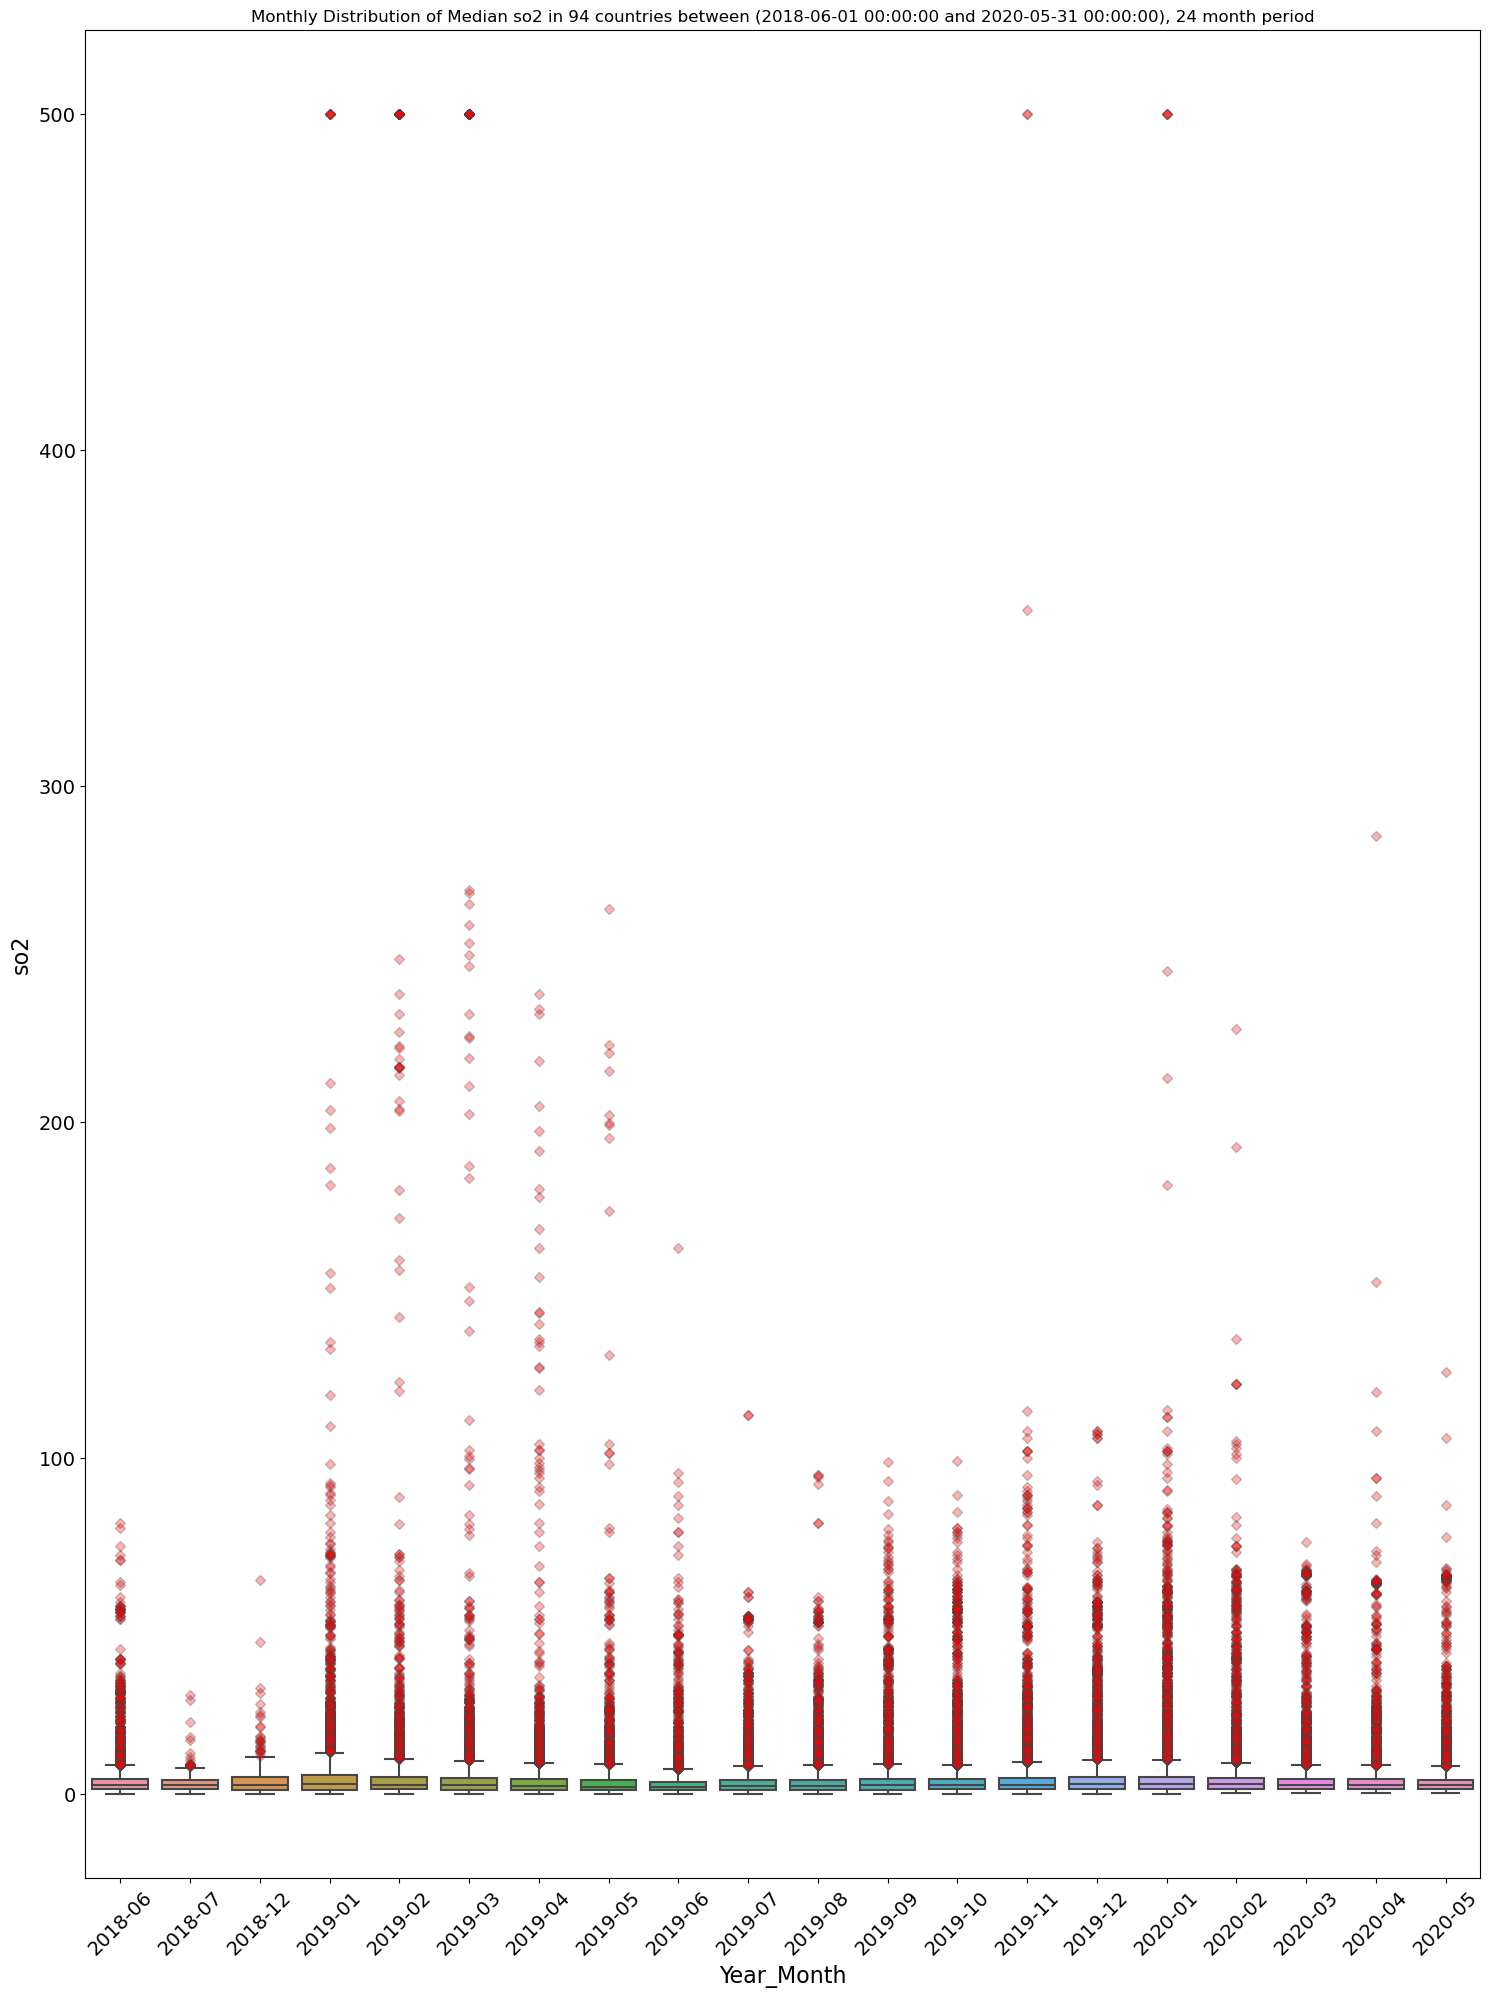

In [120]:
specie_boxplot("so2")

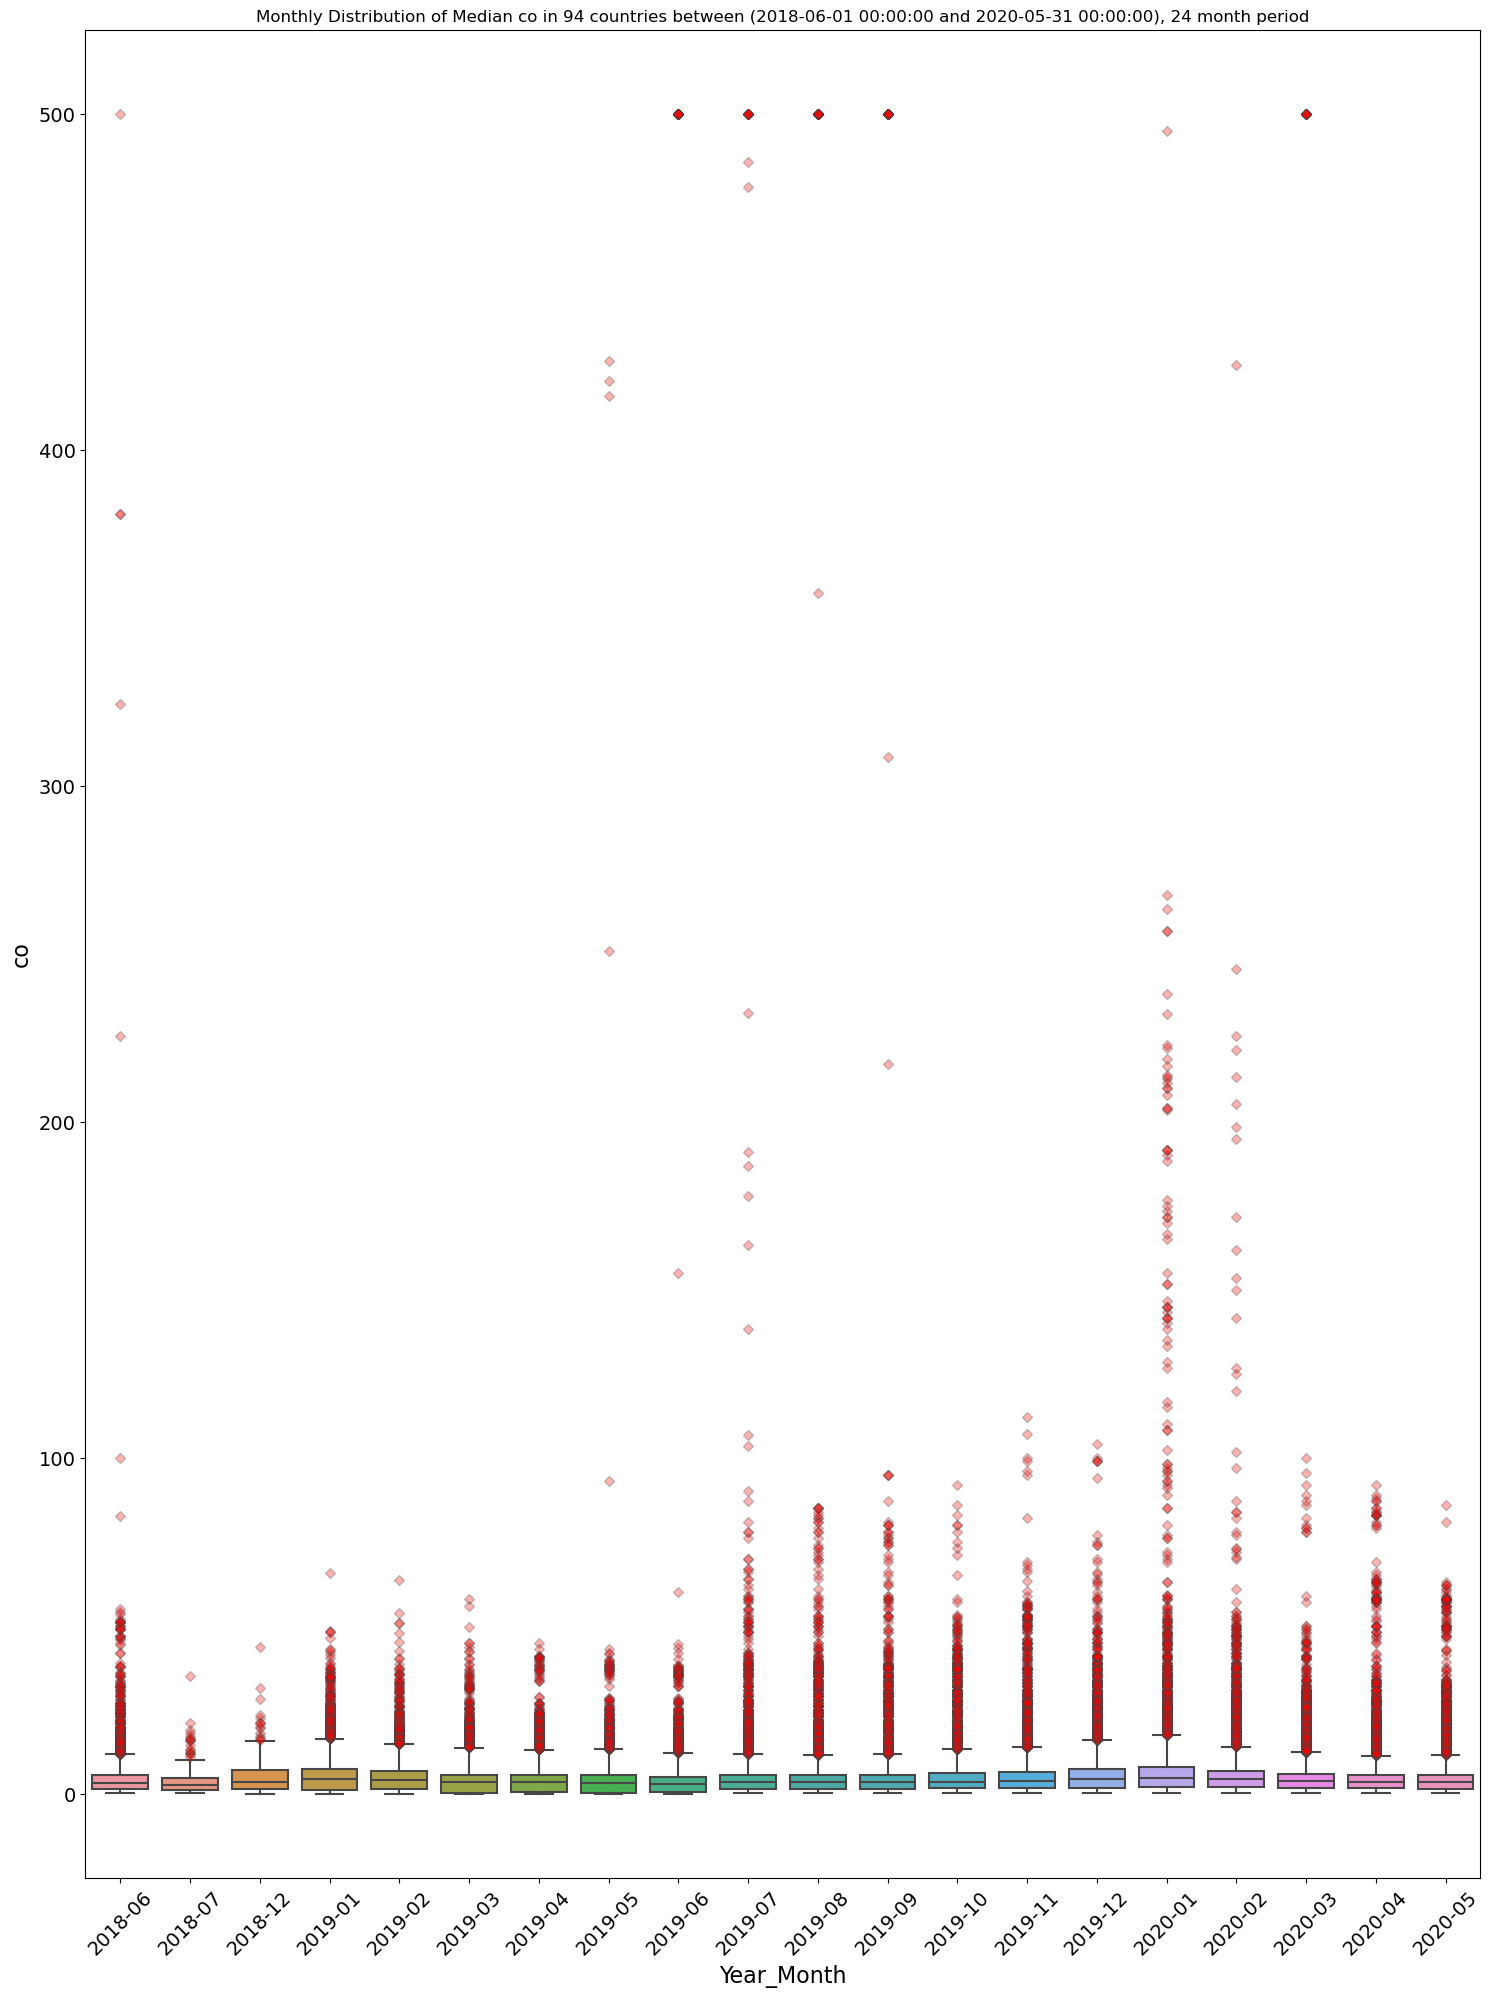

In [121]:
specie_boxplot("co")

> **Analysis of outliers and boxplots**
>
> Each of the boxplots for 6 pollutant categories shows presence of outliers
> 
> We have decided not to remove these outliers in our analysis. 3 reasons as below
> 
>  - The median for all 6 pollutants is largely in the centre of the box

>  - This tells us the data is tending towards beng symmetric

>  - Therefore we can now focus on specific cities in a country and look at 2 variables for thse countries namely population and elevation
> 
> **Next steps in analysis**
> 
> Identify cities with similar populations and differing elevations
> 
> Plot air quality data to check if elevation of a city is correlated to air quality 

## Visualise air quality change in India for 2 cities
> Delhi: Population 11m, Elevation 227m
> 
> Mumbai: Population 12m, Elevation 8m

In [56]:
# Filter out the clean_airdf part of Melbourne
del_air_df = clean_airdf.loc[(clean_airdf["Country"] == "IN") & (
    clean_airdf["City"] == "Delhi")].sort_values("Date").set_index("Date")
del_air_df.head()

Country   City Specie  count   min    max  median  variance
Date                                                                  
2018-06-01      IN  Delhi    no2    442   1.0  169.8    11.8   4145.29
2018-06-01      IN  Delhi     co    398   0.1  230.2     7.3   1360.74
2018-06-01      IN  Delhi     o3    351   1.1  134.5    17.6   4264.22
2018-06-01      IN  Delhi   pm10    351  64.0  999.0   135.0  42088.40
2018-06-01      IN  Delhi    so2    440   0.4   38.0     6.2    301.77

In [57]:
# Overview of the air pollutants appearing in the Melbourne air quality data
del_air_df["Specie"].value_counts()

Specie
no2     562
co      562
o3      562
pm10    562
so2     562
pm25    562
Name: count, dtype: int64

In [65]:
# Define a function plotting air pollutant changes in Delhi using the rolling windows
# Rolling windows overlap and "roll" along at the same frequency as the data.
# Therefore, the transformed time series is at the same frequency as the original ones.


def del_air_specie(specie):
    specie_del_air = del_air_df[del_air_df["Specie"] == specie]
    rolling_median_specie_del_air = specie_del_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_del_air.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"30-day Moving Average of Median {specie} values in Delhi over 24 months", fontsize=14)

    plt.savefig(f"images/delhi_{specie}.png")

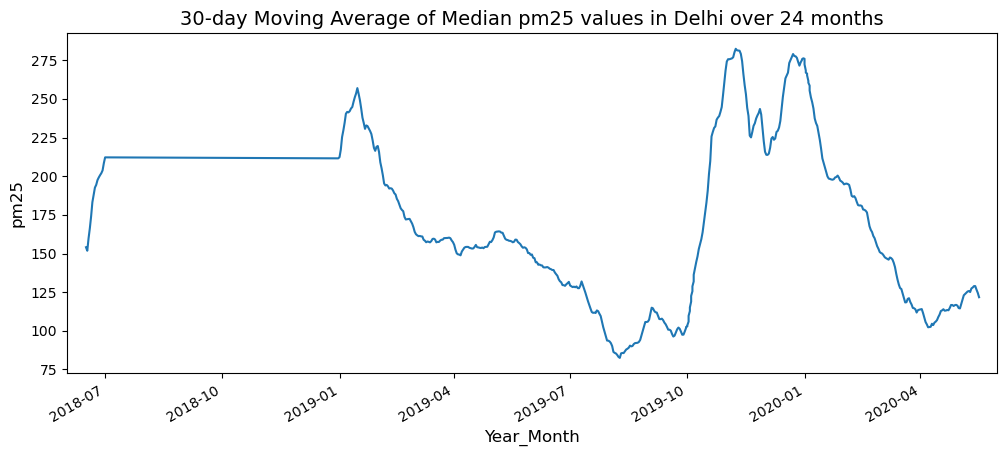

In [66]:
del_air_specie("pm25")

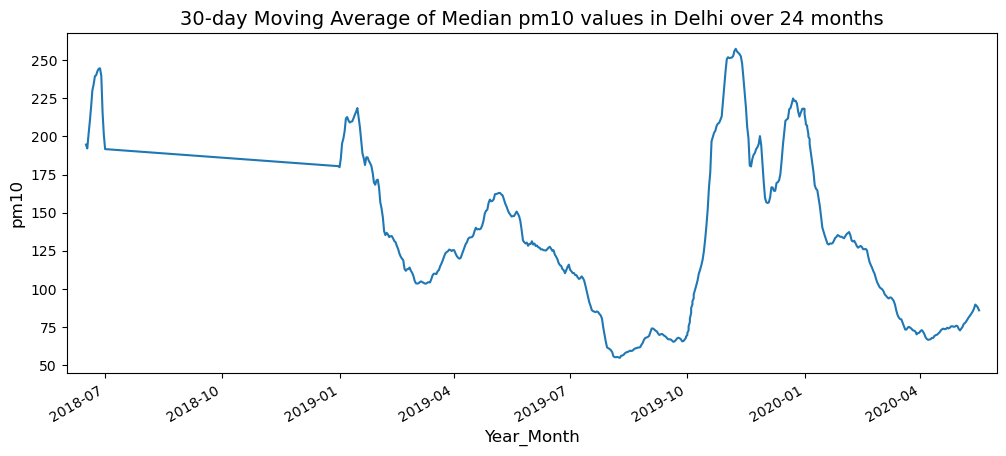

In [67]:
del_air_specie("pm10")

> The spike in particulate matter in Delhi during Oct - Jan periods can be attributed to winter season, where rural population will burn boimass to keep warmth

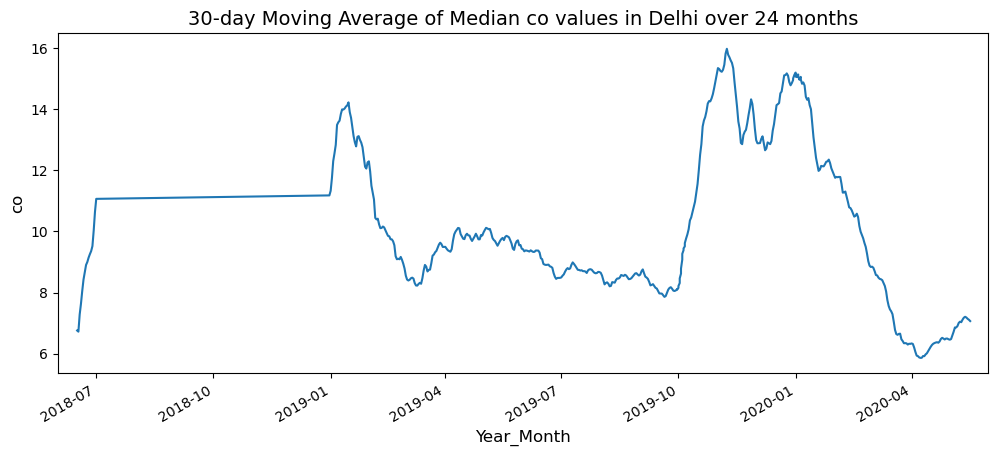

In [68]:
del_air_specie("co")

> The CO level in Delhi shows a seasonal rise possibly caused by fossil fuel combustion related to season and human activity 

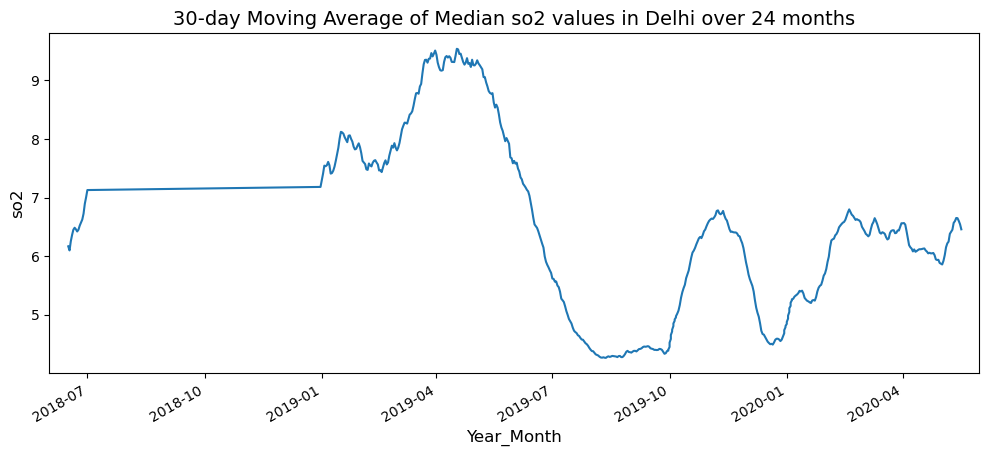

In [69]:
del_air_specie("so2")

> The SO2 level in Delhi dropped drastically from Apr 2019 extending into 2020. This maay be related to COVID restricitons causing a decline in human activity

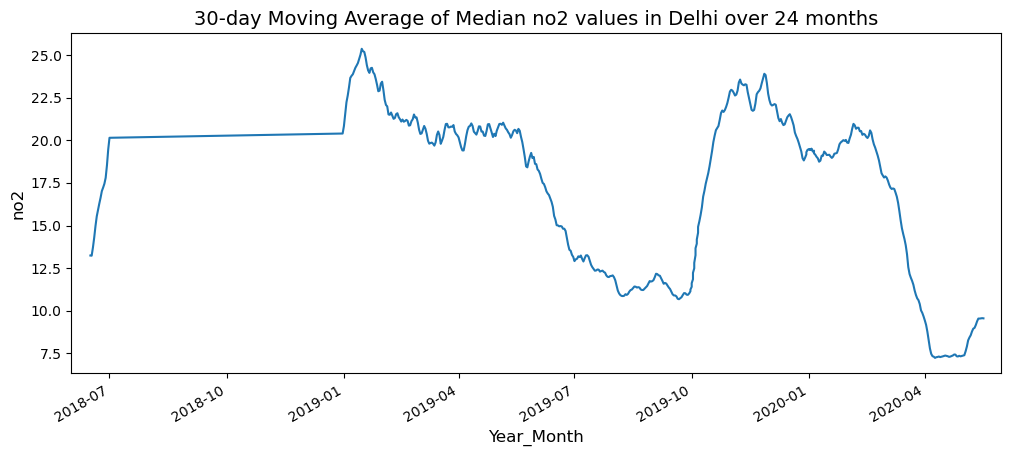

In [70]:
del_air_specie("no2")

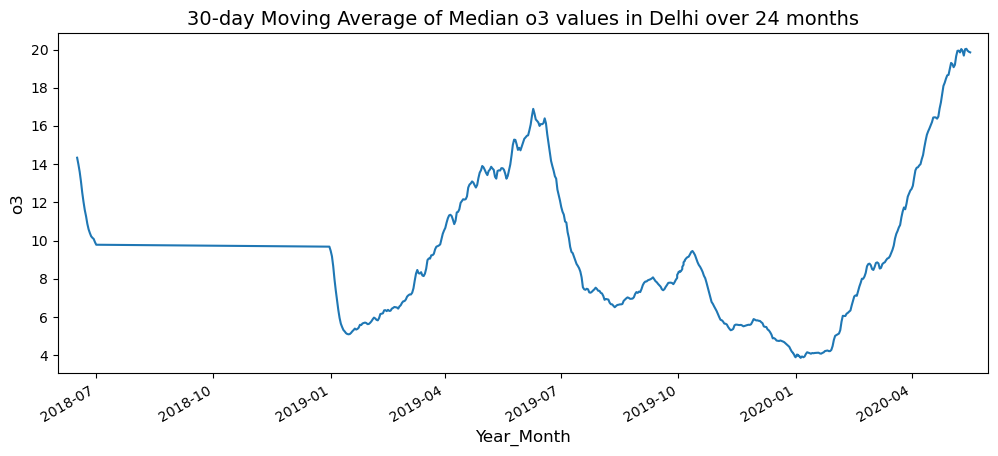

In [75]:
del_air_specie("o3")

> Delhi seems to experience a significant rise in human activity from Feb till the monsoons arrive in India in June, when the pollutant levels commence to decline

* **We now compare the air between Delhi and Mumbai**

In [83]:
# Define a function plotting air pollutant changes in different cities using the rolling windows


def specie_cities(df, city_list, specie):

    specie_cities_df = df[(df["City"].isin(city_list)) & (
        df["Specie"] == specie)].sort_values("Date").copy()
    specie_cities_transposed_df = specie_cities_df.pivot_table(
        index="Date", columns="City", values="median")
    rolling_specie_cities = specie_cities_transposed_df[city_list].rolling(
        7, center=True).mean()

    #plt.style.use('seaborn-bright')
    rolling_specie_cities.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"7 day Moving Average of median {specie} in {city_list} in 24 months", fontsize=14)
    plt.savefig(f"images/{city_list}_{specie}.png")

In [84]:
# Filter out air quality data for Australia

in_air_df = clean_airdf.loc[clean_airdf["Country"] == "IN"]
in_air_df.head()

Date Country      City Specie  count  min   max  median  variance
422490 2020-02-24      IN  Thrissur     co     24  2.1  11.2     5.3     58.36
422491 2020-04-07      IN  Thrissur     co     72  2.3  13.6     8.1    131.11
422492 2020-04-24      IN  Thrissur     co     67  1.4  12.2     9.2    126.02
422497 2020-01-03      IN  Thrissur     co     24  3.2  16.7     8.6    176.06
422498 2020-01-20      IN  Thrissur     co     21  0.4  10.6     5.1    105.15

In [85]:
in_cities_list = ["Delhi", "Mumbai"]

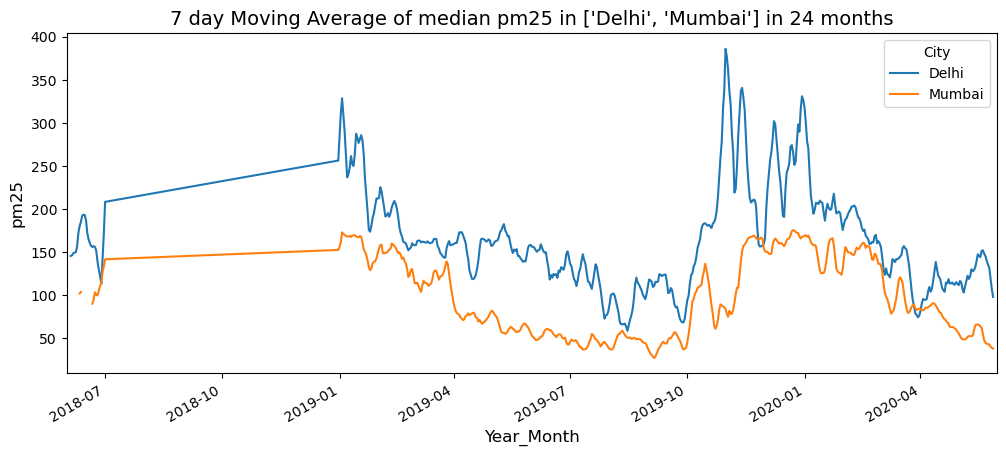

In [86]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="pm25")

> Delhi trends over Mumbai consistently in pm25. Clearly seasonal variations caused by elevation impact air quality

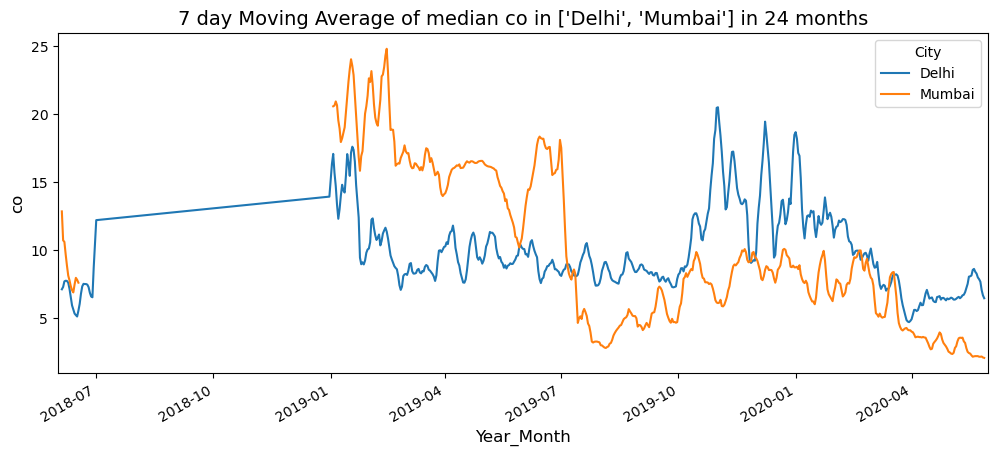

In [87]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="co")

> CO emissions in Mumbai have significantly fallen in 2020 while those in Delhi have maintained their trend and are trending above Mumbai in 2020 COVID and significant uptake in electric vehicles compared to Delhi could be contributing factors

##  Visualise air quality change in China for 2 cities
>
> Guangzao: Population 19m. Elevation 21m
>
>Chengdu:  Population 21m. Elevation 529m

In [89]:
# Filter out air quality data for China

cn_air_df = clean_airdf.loc[clean_airdf["Country"] == "CN"]
cn_air_df.head()

Date Country     City Specie  count  min   max  median  variance
14794 2020-03-13      CN  Beijing     co    276  1.0   8.2     2.8     14.10
14795 2020-03-23      CN  Beijing     co    427  1.0   9.1     4.6     18.34
14796 2020-03-26      CN  Beijing     co    265  1.0  10.0     2.8     42.63
14797 2020-04-08      CN  Beijing     co    428  1.9  10.0     4.6     25.10
14799 2020-01-02      CN  Beijing     co    434  5.4  25.3    11.8     88.73

In [90]:
# Overview of the cities in the air data for China
cn_air_df["City"].value_counts()

City
Beijing         3378
Zhuzhou         3378
Qinhuangdao     3378
Shijiazhuang    3378
Jieyang         3378
Zhengzhou       3378
Nanjing         3378
Xining          3378
Xi’an           3378
Nanchang        3378
Fushun          3378
Harbin          3378
Lanzhou         3378
Changsha        3378
Anyang          3378
Taiyuan         3378
Fuzhou          3378
Xiamen          3378
Chengdu         3378
Shantou         3378
Nanning         3378
Guiyang         3378
Kunming         3378
Ürümqi          3378
Changchun       3378
Qiqihar         3378
Lhasa           3378
Shenyang        3378
Yinchuan        3378
Haikou          3378
Chongqing       3378
Qingdao         3378
Hegang          3377
Hefei           3377
Xinxiang        3376
Jinan           3376
Hangzhou        3374
Xuchang         3362
Wuhan           3357
Shenzhen        3356
Shanghai        3347
Guangzhou       3343
Dongguan        3343
Foshan          3343
Yunfu           3342
Ningbo          3078
Suzhou          3051
Changzho

In [91]:
# Overview of the air pollutants in the air data for China
cn_air_df["Specie"].value_counts()

Specie
pm25    29223
so2     29223
co      29222
pm10    29222
no2     29222
o3      26332
Name: count, dtype: int64

In [92]:
cn_cities_list = ["Chengdu", "Guangzhou"]

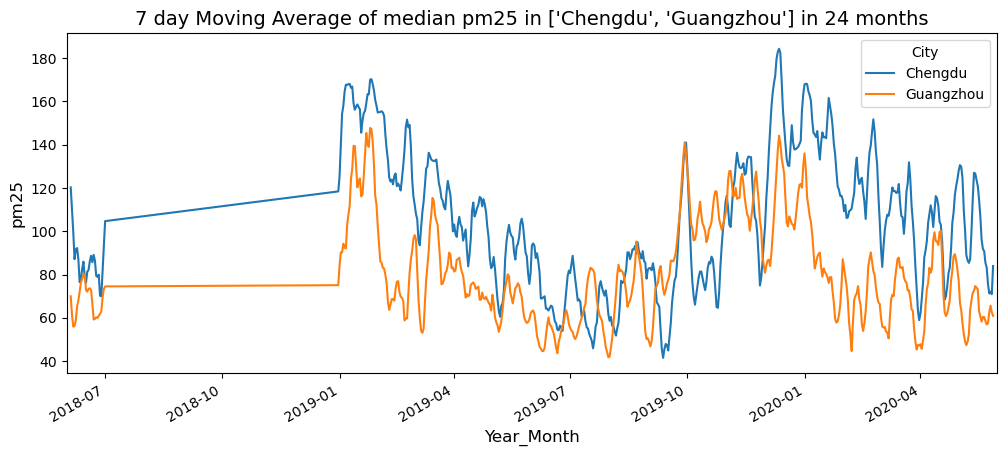

In [95]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="pm25")

> Chendu mirrors the trend as in Delhi, wherein seasonal cold weather is influencing pm25. And this seasonal variation is related to its elevation compared to Guangzhou

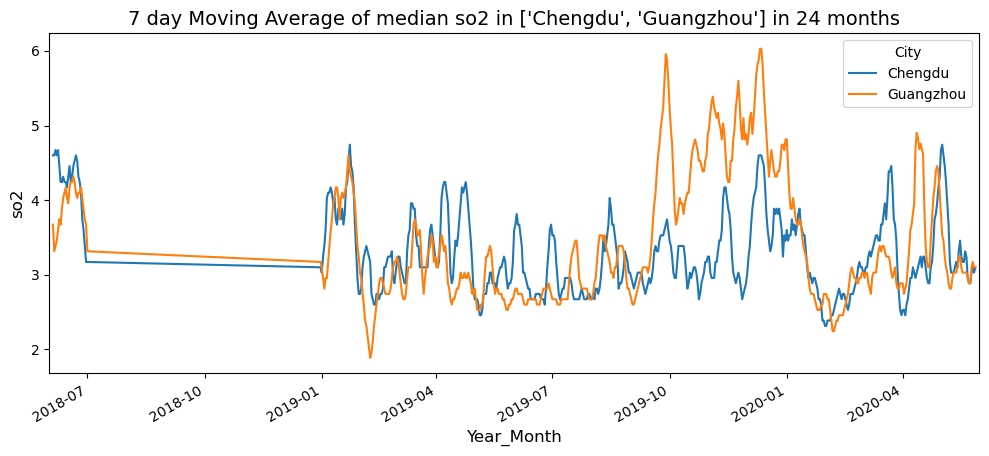

In [96]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="so2")

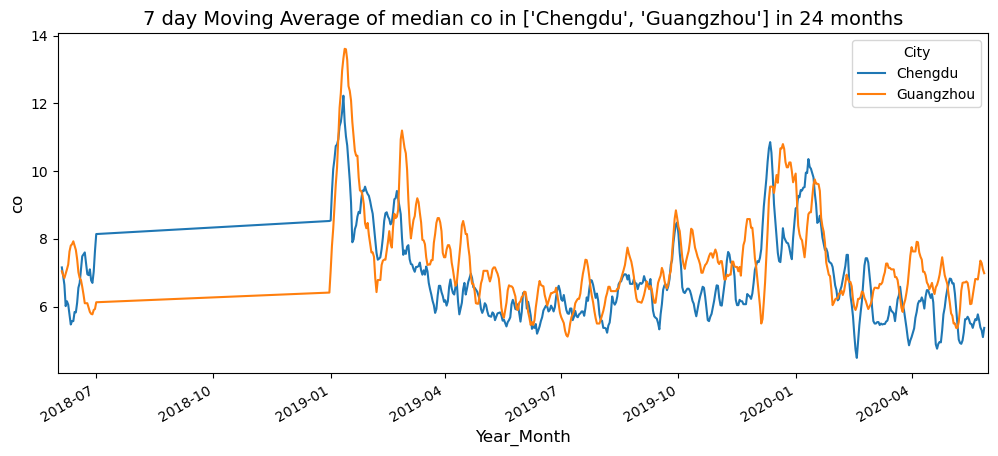

In [97]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="co")

> Guangzhao is a significant established manufacturing centre and Chengdu is an upcoming logistics hub. Both are mirroring the same trend for CO and SO2

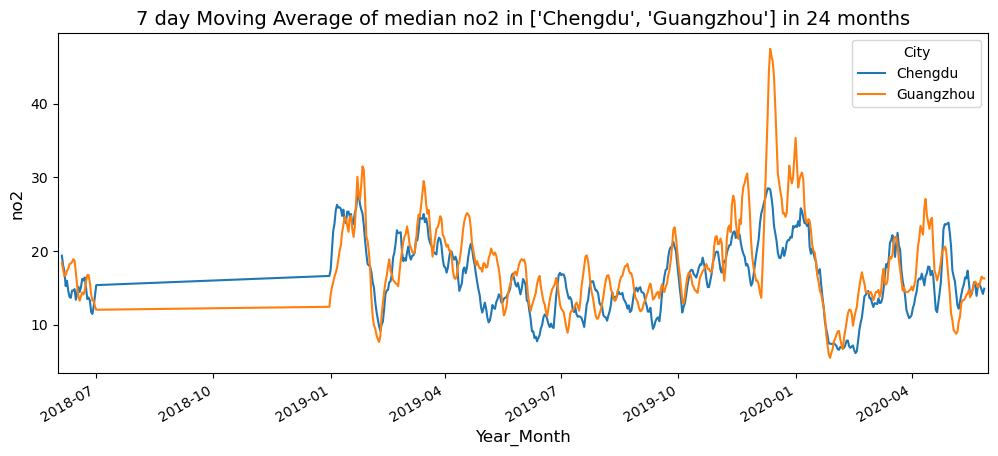

In [98]:
specie_cities(df=cn_air_df, city_list=cn_cities_list, specie="no2")

> Guangzhao is a significant established manufacturing centre and Chengdu is an upcoming logistics hub. Both are mirroring the same trend for CO, SO2 and NO2
>
> Implcations for Chengdu though because of its elevation in terms of air pollution as evidenced by pm25 could be more intense as economic activity increases in Chengdu

## Visualise air quality in Mumbai and Chengdu
>
>Mumbai has a population of 12m and elevation of 8m
>
>Chengdu has a population of 21m and elevation of 529m
>
>Given higher elevation and 80% more population it will interesting to see if air quality can be influenced by interventions


In [99]:
in_air_df.head()

Date Country      City Specie  count  min   max  median  variance
422490 2020-02-24      IN  Thrissur     co     24  2.1  11.2     5.3     58.36
422491 2020-04-07      IN  Thrissur     co     72  2.3  13.6     8.1    131.11
422492 2020-04-24      IN  Thrissur     co     67  1.4  12.2     9.2    126.02
422497 2020-01-03      IN  Thrissur     co     24  3.2  16.7     8.6    176.06
422498 2020-01-20      IN  Thrissur     co     21  0.4  10.6     5.1    105.15

In [101]:
# Filter the air data for Mumbai
mumbai_air_df = in_air_df[in_air_df["City"] == "Mumbai"].sort_values(
    "Date").set_index("Date").copy()
mumbai_air_df.head()

Country    City Specie  count   min    max  median  variance
Date                                                                   
2018-06-01      IN  Mumbai   pm10     24  65.0   83.0    69.0    354.18
2018-06-01      IN  Mumbai   pm25     23  87.0  134.0   107.0   2517.94
2018-06-01      IN  Mumbai    so2     24  16.5   23.6    18.0     57.23
2018-06-01      IN  Mumbai     co     24  10.8   26.2    25.3    431.74
2018-06-02      IN  Mumbai    so2     24  16.0   22.3    19.7     54.31

In [103]:
# Filter the air data for Chengdu
chengdu_air_df = cn_air_df[cn_air_df["City"] == "Chengdu"].sort_values(
    "Date").set_index("Date").copy()
chengdu_air_df.head()

Country     City Specie  count   min    max  median  variance
Date                                                                    
2018-06-01      CN  Chengdu   pm10    602  14.0  100.0    59.0   1630.00
2018-06-01      CN  Chengdu     co    582   2.0   16.0     6.0     52.20
2018-06-01      CN  Chengdu    no2    620   0.5   45.7    15.6    630.35
2018-06-01      CN  Chengdu   pm25    656  38.0  824.0   129.0  15983.00
2018-06-01      CN  Chengdu     o3    619   0.5   91.6    28.5   2222.85

In [112]:
# Define a function plotting air pollutant changes in Mumbai and Chengdu using the rolling windows


def che_mum_air_specie(specie):
    specie_mumbai_air = mumbai_air_df[mumbai_air_df["Specie"] == specie]
    specie_che_air = chengdu_air_df[chengdu_air_df["Specie"] == specie]

    rolling_median_specie_mumbai_air = specie_mumbai_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_mumbai_air.plot(figsize=(12, 5), label="Mumbai")
    rolling_median_specie_che_air = specie_che_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_che_air.plot(figsize=(12, 5), label="Chengdu")

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.legend()
    plt.title(f"30-day Moving Average of Median {specie} values in Chengdu and Mumbai", fontsize=14)
    plt.savefig(f"images/chengdu_mumbai_{specie}.png")

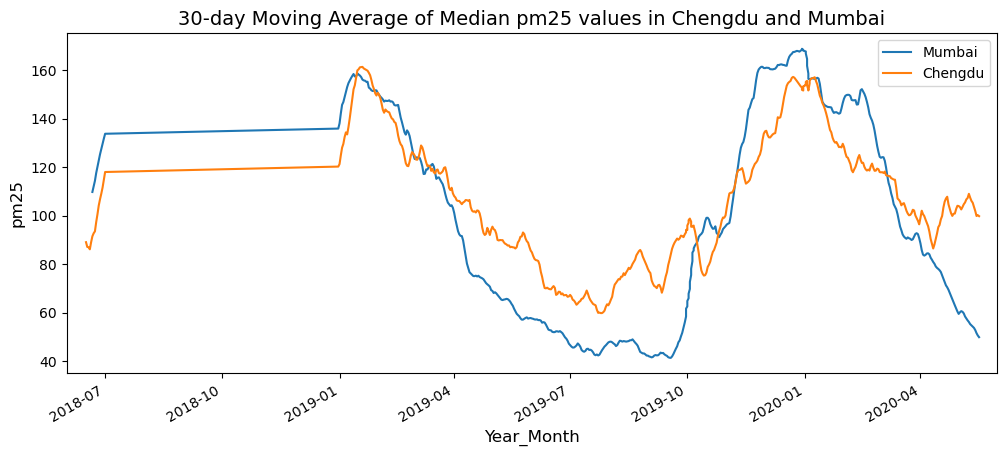

In [113]:
che_mum_air_specie("pm25")

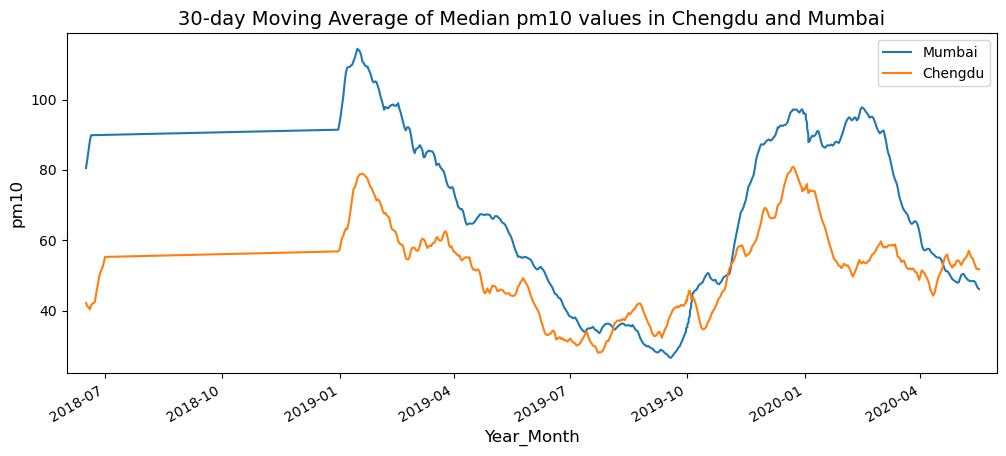

In [114]:
che_mum_air_specie("pm10")

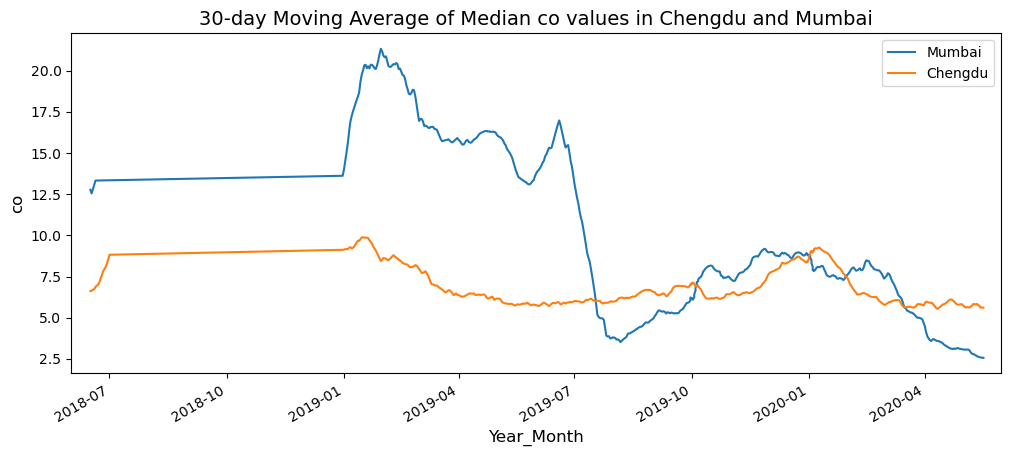

In [115]:
che_mum_air_specie("co")

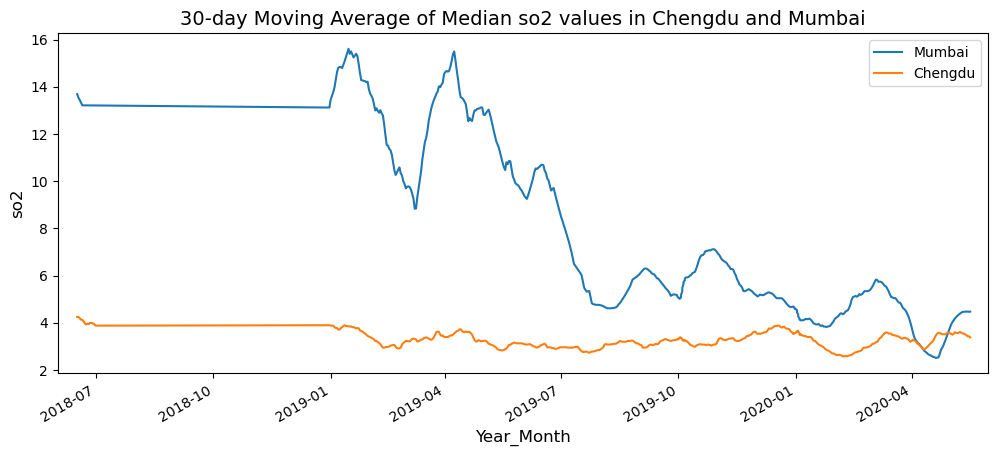

In [117]:
che_mum_air_specie("so2")

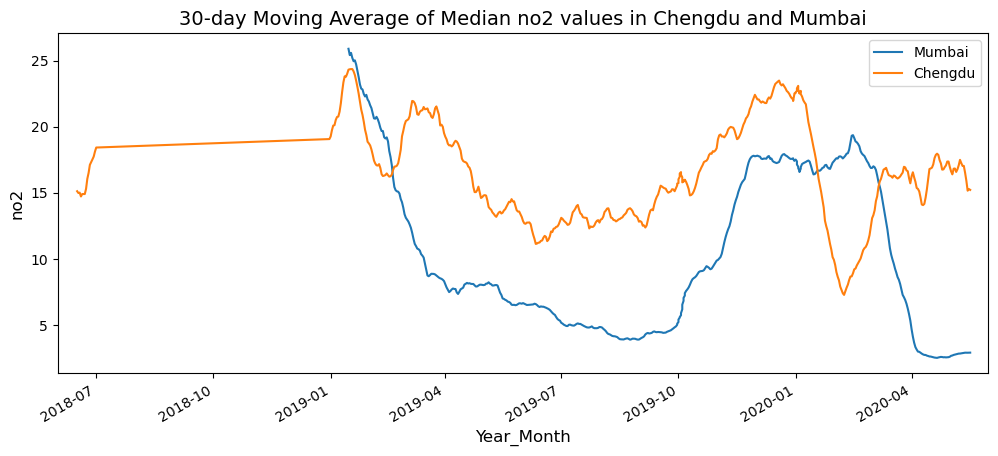

In [118]:
che_mum_air_specie("no2")

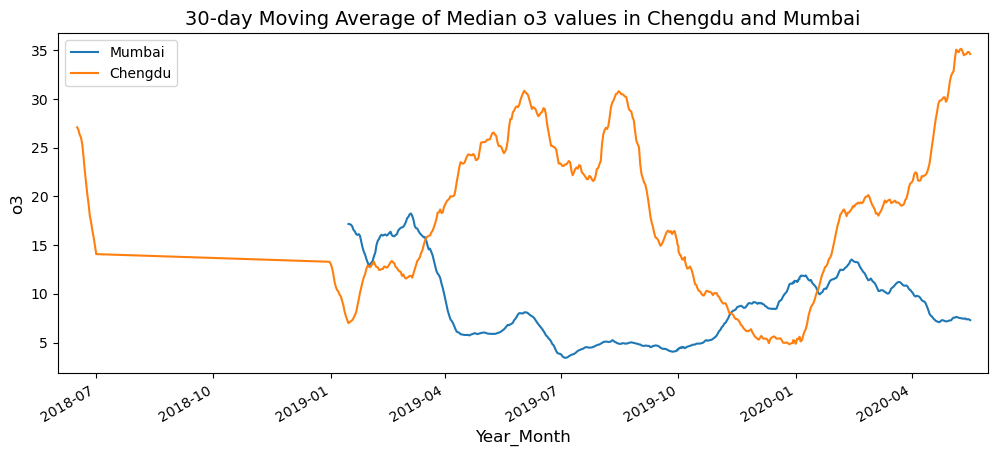

In [119]:
che_mum_air_specie("o3")

* Chengdu and Mumbai comprisons yield interesting results
>
>o3 and no2 levels in Chengdu are higher than in Mumbai, suggesting increased elevation of Chengdu makes it susceptible to these 2 air pollutants
>
>On other parameters such as pm25, pm10, co, so2 Mumbai scores higher though its smaller than Chengdu and a coastal city, suggesting Mumbai can learn from Chengdu in terms of managing these air pollutants through clean technology

## COVID-19 World Data Exploration and Clean Up

### Explore the Covid-19 Country API

In [65]:
# Use the following api to get the country name, country code and slug
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

[{'Country': 'Nigeria', 'ISO2': 'NG', 'Slug': 'nigeria'},
 {'Country': 'Slovenia', 'ISO2': 'SI', 'Slug': 'slovenia'},
 {'Country': 'Antarctica', 'ISO2': 'AQ', 'Slug': 'antarctica'},
 {'Country': 'Bolivia', 'ISO2': 'BO', 'Slug': 'bolivia'},
 {'Country': 'Guinea-Bissau', 'ISO2': 'GW', 'Slug': 'guinea-bissau'},
 {'Country': 'Monaco', 'ISO2': 'MC', 'Slug': 'monaco'},
 {'Country': 'Cuba', 'ISO2': 'CU', 'Slug': 'cuba'},
 {'Country': 'Spain', 'ISO2': 'ES', 'Slug': 'spain'},
 {'Country': 'Azerbaijan', 'ISO2': 'AZ', 'Slug': 'azerbaijan'},
 {'Country': 'Benin', 'ISO2': 'BJ', 'Slug': 'benin'},
 {'Country': 'Congo (Kinshasa)', 'ISO2': 'CD', 'Slug': 'congo-kinshasa'},
 {'Country': 'Barbados', 'ISO2': 'BB', 'Slug': 'barbados'},
 {'Country': 'Suriname', 'ISO2': 'SR', 'Slug': 'suriname'},
 {'Country': 'French Guiana', 'ISO2': 'GF', 'Slug': 'french-guiana'},
 {'Country': 'India', 'ISO2': 'IN', 'Slug': 'india'},
 {'Country': 'Papua New Guinea', 'ISO2': 'PG', 'Slug': 'papua-new-guinea'},
 {'Country': 'Ch

In [66]:
# Create the country code dataframe
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

Country                    Slug ISO2
0                   Nigeria                 nigeria   NG
1                  Slovenia                slovenia   SI
2                Antarctica              antarctica   AQ
3                   Bolivia                 bolivia   BO
4             Guinea-Bissau           guinea-bissau   GW
..                      ...                     ...  ...
243                  Zambia                  zambia   ZM
244  British Virgin Islands  british-virgin-islands   VG
245       Brunei Darussalam                  brunei   BN
246                Cambodia                cambodia   KH
247                Maldives                maldives   MV

[248 rows x 3 columns]

In [67]:
# The country code is used to merge with the air quality data (with country code only)
final_air_df = pd.merge(clean_airdf, country_covid_df, how="inner",
                        left_on="Country", right_on="ISO2", suffixes=("_code", "_name"))
final_air_df.head(10)

Date Country_code     City Specie  count   min    max  median  \
0 2020-02-24           IR  Isfahan   pm25    129  54.0  194.0   126.0   
1 2020-05-07           IR  Isfahan   pm25    168  17.0  168.0    91.0   
2 2020-05-28           IR  Isfahan   pm25    127  17.0  115.0    72.0   
3 2020-02-20           IR  Isfahan   pm25    113  26.0  181.0    76.0   
4 2020-02-23           IR  Isfahan   pm25    132  22.0  132.0    76.0   
5 2020-05-19           IR  Isfahan   pm25    168  31.0  172.0    89.0   
6 2020-05-30           IR  Isfahan   pm25    115  36.0  164.0    78.0   
7 2020-01-22           IR  Isfahan   pm25    145  59.0  141.0    91.0   
8 2020-01-23           IR  Isfahan   pm25    134  42.0  109.0    63.0   
9 2020-03-06           IR  Isfahan   pm25     94  58.0  195.0   111.0   

   variance               Country_name  Slug ISO2  
0  10921.40  Iran, Islamic Republic of  iran   IR  
1  14014.00  Iran, Islamic Republic of  iran   IR  
2   3558.56  Iran, Islamic Republic of  iran   IR  
3  11209.80  Iran, Islamic Republic of  iran   IR  
4   3209.67  Iran, Islamic Republic of  iran   IR  
5   6310.77  Iran, Islamic Republic of  iran   IR  
6   5630.48  Iran, Islamic Republic of  iran   IR  
7   4123.42  Iran, Islamic Republic of  iran   IR  
8   1529.14  Iran, Islamic Republic of  iran   IR  
9   9950.79  Iran, Islamic Republic of  iran   IR

In [68]:
# Delete the ISO2 which is identical to the country_code column
del final_air_df["ISO2"]
final_air_df.head()

Date Country_code     City Specie  count   min    max  median  \
0 2020-02-24           IR  Isfahan   pm25    129  54.0  194.0   126.0   
1 2020-05-07           IR  Isfahan   pm25    168  17.0  168.0    91.0   
2 2020-05-28           IR  Isfahan   pm25    127  17.0  115.0    72.0   
3 2020-02-20           IR  Isfahan   pm25    113  26.0  181.0    76.0   
4 2020-02-23           IR  Isfahan   pm25    132  22.0  132.0    76.0   

   variance               Country_name  Slug  
0  10921.40  Iran, Islamic Republic of  iran  
1  14014.00  Iran, Islamic Republic of  iran  
2   3558.56  Iran, Islamic Republic of  iran  
3  11209.80  Iran, Islamic Republic of  iran  
4   3209.67  Iran, Islamic Republic of  iran

In [69]:
final_air_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475237 entries, 0 to 1475236
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1475237 non-null  datetime64[ns]
 1   Country_code  1475237 non-null  object        
 2   City          1475237 non-null  object        
 3   Specie        1475237 non-null  object        
 4   count         1475237 non-null  int64         
 5   min           1475237 non-null  float64       
 6   max           1475237 non-null  float64       
 7   median        1475237 non-null  float64       
 8   variance      1475237 non-null  float64       
 9   Country_name  1475237 non-null  object        
 10  Slug          1475237 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 135.1+ MB


### Explore the Covid-19 Country by All case status API 

In [70]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

[{'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-22T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-23T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-24T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-25T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 4,
  'City': '',
  'CityCode': '',
  'Confirmed': 4,
  'Country': 'Australia',
  'Co

  'Deaths': 60,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 1806},
 {'Active': 4484,
  'City': '',
  'CityCode': '',
  'Confirmed': 6351,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-13T00:00:00Z',
  'Deaths': 61,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 1806},
 {'Active': 4167,
  'City': '',
  'CityCode': '',
  'Confirmed': 6415,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-14T00:00:00Z',
  'Deaths': 62,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 2186},
 {'Active': 4191,
  'City': '',
  'CityCode': '',
  'Confirmed': 6440,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-15T00:00:00Z',
  'Deaths': 63,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 2186},
 {'Active': 4044,
  'City': '',
  'CityCode': '',
  'Confirmed': 6462,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-16T00:00:00Z',
  'Deaths': 63,
  'Lat': '0',
  'Lon': '0',
  'Province'

  'Deaths': 104,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 7090},
 {'Active': 832,
  'City': '',
  'CityCode': '',
  'Confirmed': 8066,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-07-02T00:00:00Z',
  'Deaths': 104,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 7130},
 {'Active': 837,
  'City': '',
  'CityCode': '',
  'Confirmed': 8260,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-07-03T00:00:00Z',
  'Deaths': 104,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 7319},
 {'Active': 940,
  'City': '',
  'CityCode': '',
  'Confirmed': 8443,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-07-04T00:00:00Z',
  'Deaths': 104,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 7399},
 {'Active': 1057,
  'City': '',
  'CityCode': '',
  'Confirmed': 8583,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-07-05T00:00:00Z',
  'Deaths': 106,
  'Lat': '0',
  'Lon': '0',
  'Provinc

The above api example covers the covid-19 data up-to-date. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through the countries in our air quality data.

In [71]:
slug_list = final_air_df["Slug"].unique().tolist()
len(slug_list)

93

In [72]:
# Use the slug list to loop through the Covid-19 API by all case status for each country.
base_covid_url = "https://api.covid19api.com/total/country/"

country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:

    try:
        response = requests.get(base_covid_url + slug).json()

        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

Beginning Data Retrieval
-----------------------------------
Processing Record 1 of Set 1 | iran
Processing Record 2 of Set 1 | tajikistan
Processing Record 3 of Set 1 | brazil
Processing Record 4 of Set 1 | china
Processing Record 5 of Set 1 | denmark
Processing Record 6 of Set 1 | spain
Processing Record 7 of Set 1 | mali
Processing Record 8 of Set 1 | slovakia
Processing Record 9 of Set 1 | kosovo
Processing Record 10 of Set 1 | chile
Processing Record 11 of Set 1 | germany
Processing Record 12 of Set 1 | kuwait
Processing Record 13 of Set 1 | myanmar
Processing Record 14 of Set 1 | philippines
Processing Record 15 of Set 1 | pakistan
Processing Record 16 of Set 1 | poland
Processing Record 17 of Set 1 | russia
Processing Record 18 of Set 1 | sweden
Processing Record 19 of Set 1 | singapore
Processing Record 20 of Set 1 | united-arab-emirates
Processing Record 21 of Set 1 | bosnia-and-herzegovina
Processing Record 22 of Set 1 | czech-republic
Processing Record 23 of Set 1 | indonesi

In [73]:
# Create the world covid dataframe
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

Country                  Date  Active cases  \
0  Iran, Islamic Republic of  2020-01-22T00:00:00Z             0   
1  Iran, Islamic Republic of  2020-01-23T00:00:00Z             0   
2  Iran, Islamic Republic of  2020-01-24T00:00:00Z             0   
3  Iran, Islamic Republic of  2020-01-25T00:00:00Z             0   
4  Iran, Islamic Republic of  2020-01-26T00:00:00Z             0   

   Confirmed cases  Recovered cases  Deaths  
0                0                0       0  
1                0                0       0  
2                0                0       0  
3                0                0       0  
4                0                0       0

In [74]:
# Overview of the covid dataframe
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          15223 non-null  object
 1   Date             15223 non-null  object
 2   Active cases     15223 non-null  int64 
 3   Confirmed cases  15223 non-null  int64 
 4   Recovered cases  15223 non-null  int64 
 5   Deaths           15223 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 713.7+ KB


In [75]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [76]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

Timestamp('2020-01-22 00:00:00')

In [77]:
# Find the latest date the covid dataset covers:
covid_df["Date"].max()

Timestamp('2020-07-12 00:00:00')

In [78]:
# Set cutoff date to the 1st July 2020
world_covid_df = covid_df[covid_df["Date"] <= end_date]

In [79]:
# Overview of world_covid_df after setting cutoff date
world_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14256 entries, 0 to 15211
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          14256 non-null  object        
 1   Date             14256 non-null  datetime64[ns]
 2   Active cases     14256 non-null  int64         
 3   Confirmed cases  14256 non-null  int64         
 4   Recovered cases  14256 non-null  int64         
 5   Deaths           14256 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 779.6+ KB


In [80]:
# Check the number of unique countries in the world_covid_df
world_covid_df["Country"].nunique()

88

In [81]:
# Export the list of countries that are shared by the air data and world covid data
air_covid_common_country_list = world_covid_df["Country"].unique().tolist()
air_covid_common_country_list

['Iran, Islamic Republic of',
 'Tajikistan',
 'Brazil',
 'China',
 'Denmark',
 'Spain',
 'Mali',
 'Slovakia',
 'Republic of Kosovo',
 'Chile',
 'Germany',
 'Kuwait',
 'Myanmar',
 'Philippines',
 'Pakistan',
 'Poland',
 'Russian Federation',
 'Sweden',
 'Singapore',
 'United Arab Emirates',
 'Bosnia and Herzegovina',
 'Czech Republic',
 'Indonesia',
 'Iceland',
 'Romania',
 'Argentina',
 'Australia',
 'Ecuador',
 'Ghana',
 'Peru',
 'Ukraine',
 'Estonia',
 'France',
 'Japan',
 'Mongolia',
 'Finland',
 'Ireland',
 'Israel',
 'Kazakhstan',
 'Lao PDR',
 'Uzbekistan',
 'Bangladesh',
 'Belgium',
 'Greece',
 'Korea (South)',
 'Sri Lanka',
 'Macedonia, Republic of',
 'Mexico',
 'Turkey',
 'Afghanistan',
 'Austria',
 'Guatemala',
 'Bolivia',
 'Costa Rica',
 'Jordan',
 'Saudi Arabia',
 'El Salvador',
 'Canada',
 'Italy',
 'Norway',
 'South Africa',
 'Bahrain',
 'Lithuania',
 'Thailand',
 'Bulgaria',
 'Switzerland',
 'Hungary',
 'Netherlands',
 'New Zealand',
 'Uganda',
 'Viet Nam',
 'Ethiopia',
 

In [82]:
# Filter out the air quality data to contain only the above countries
final_clean_air_df = final_air_df[final_air_df["Country_name"].isin(
    air_covid_common_country_list)]
final_clean_air_df.head()

Date Country_code     City Specie  count   min    max  median  \
0 2020-02-24           IR  Isfahan   pm25    129  54.0  194.0   126.0   
1 2020-05-07           IR  Isfahan   pm25    168  17.0  168.0    91.0   
2 2020-05-28           IR  Isfahan   pm25    127  17.0  115.0    72.0   
3 2020-02-20           IR  Isfahan   pm25    113  26.0  181.0    76.0   
4 2020-02-23           IR  Isfahan   pm25    132  22.0  132.0    76.0   

   variance               Country_name  Slug  
0  10921.40  Iran, Islamic Republic of  iran  
1  14014.00  Iran, Islamic Republic of  iran  
2   3558.56  Iran, Islamic Republic of  iran  
3  11209.80  Iran, Islamic Republic of  iran  
4   3209.67  Iran, Islamic Republic of  iran

In [83]:
# Double check the number of countries in the final clean air data
final_clean_air_df["Country_name"].nunique()

88

In [84]:
del final_clean_air_df["Slug"]
final_clean_air_df.head()

Date Country_code     City Specie  count   min    max  median  \
0 2020-02-24           IR  Isfahan   pm25    129  54.0  194.0   126.0   
1 2020-05-07           IR  Isfahan   pm25    168  17.0  168.0    91.0   
2 2020-05-28           IR  Isfahan   pm25    127  17.0  115.0    72.0   
3 2020-02-20           IR  Isfahan   pm25    113  26.0  181.0    76.0   
4 2020-02-23           IR  Isfahan   pm25    132  22.0  132.0    76.0   

   variance               Country_name  
0  10921.40  Iran, Islamic Republic of  
1  14014.00  Iran, Islamic Republic of  
2   3558.56  Iran, Islamic Republic of  
3  11209.80  Iran, Islamic Republic of  
4   3209.67  Iran, Islamic Republic of

In [85]:
# Export the air data to csv file for future use
final_clean_air_df.to_csv("output_csv/clean_world_air.csv", index=False)

### Visualise World Covid-19 Active Cases

In [86]:
world_covid_df.tail()

Country       Date  Active cases  Confirmed cases  \
15207  United States of America 2020-06-27       1704831          2510259   
15208  United States of America 2020-06-28       1737770          2549294   
15209  United States of America 2020-06-29       1758754          2590668   
15210  United States of America 2020-06-30       1788351          2636414   
15211  United States of America 2020-07-01       1829489          2687588   

       Recovered cases  Deaths  
15207           679308  126120  
15208           685164  126360  
15209           705203  126711  
15210           720631  127432  
15211           729994  128105

In [87]:
# Filter out the world covid data with active cases
world_active_covid = world_covid_df[[
    "Date", "Country", "Active cases"]].sort_values("Date").copy()
world_active_covid.head()

Date                    Country  Active cases
0     2020-01-22  Iran, Islamic Republic of             0
12801 2020-01-22                       Iraq             0
2076  2020-01-22                    Myanmar             0
12628 2020-01-22                     Guinea             0
2249  2020-01-22                Philippines             0

In [88]:
# Get the world covid active case data on the 1st July 2020
july1_world_active_covid = world_active_covid[world_active_covid["Date"]
                                              == "2020-07-01"].copy()

In [89]:
# Check the number of countries covered in the world covid active case data on the 1st July 2020
july1_world_active_covid["Country"].nunique()

88

In [90]:
# Visualise the 88 countries covered in our analysis in an interactive choropleth map

figure = px.choropleth(july1_world_active_covid, locations="Country", locationmode="country names", color="Active cases", hover_name="Country",
                       color_continuous_scale="ylorrd", range_color=[1, 700000], title="88 Countries with Number of Covid-19 Active Cases On 1st July 2020")
figure.show()

### Export covid csv files for Australia, India and world

In [91]:
# Get and export the covid active case data for Australia
au_covid = world_active_covid[world_active_covid["Country"] == "Australia"].copy()
au_covid.head()

Date    Country  Active cases
4498 2020-01-22  Australia             0
4499 2020-01-23  Australia             0
4500 2020-01-24  Australia             0
4501 2020-01-25  Australia             0
4502 2020-01-26  Australia             4

In [92]:
au_covid.to_csv("output_csv/active_au_covid.csv", index=False)

In [93]:
# Get and export the covid active case data for India
india_covid = world_active_covid[world_active_covid["Country"] == "India"].copy()
india_covid.head()

Date Country  Active cases
14185 2020-01-22   India             0
14186 2020-01-23   India             0
14187 2020-01-24   India             0
14188 2020-01-25   India             0
14189 2020-01-26   India             0

In [94]:
india_covid.to_csv("output_csv/active_india_covid.csv", index=False)

In [95]:
# Transpose the 88 countries to columns
world_active_covid_transposed = world_active_covid.pivot_table(
    index="Date", columns="Country", values="Active cases")
world_active_covid_transposed.head()

Country     Afghanistan  Algeria  Argentina  Australia  Austria  Bahrain  \
Date                                                                       
2020-01-22            0        0          0          0        0        0   
2020-01-23            0        0          0          0        0        0   
2020-01-24            0        0          0          0        0        0   
2020-01-25            0        0          0          0        0        0   
2020-01-26            0        0          0          4        0        0   

Country     Bangladesh  Belgium  Bolivia  Bosnia and Herzegovina  ...  \
Date                                                              ...   
2020-01-22           0        0        0                       0  ...   
2020-01-23           0        0        0                       0  ...   
2020-01-24           0        0        0                       0  ...   
2020-01-25           0        0        0                       0  ...   
2020-01-26           0        0        0                       0  ...   

Country     Tajikistan  Thailand  Turkey  Uganda  Ukraine  \
Date                                                        
2020-01-22           0         2       0       0        0   
2020-01-23           0         3       0       0        0   
2020-01-24           0         5       0       0        0   
2020-01-25           0         7       0       0        0   
2020-01-26           0         6       0       0        0   

Country     United Arab Emirates  United Kingdom  United States of America  \
Date                                                                         
2020-01-22                     0               0                         1   
2020-01-23                     0               0                         1   
2020-01-24                     0               0                         2   
2020-01-25                     0               0                         2   
2020-01-26                     0               0                         5   

Country     Uzbekistan  Viet Nam  
Date                              
2020-01-22           0         0  
2020-01-23           0         2  
2020-01-24           0         2  
2020-01-25           0         2  
2020-01-26           0         2  

[5 rows x 88 columns]

In [96]:
# Calculate the total active cases for the 88 countries on each Date
world_active_covid_transposed["Total active cases"] = world_active_covid_transposed.sum(axis=1)
world_active_covid_transposed.head()

Country     Afghanistan  Algeria  Argentina  Australia  Austria  Bahrain  \
Date                                                                       
2020-01-22            0        0          0          0        0        0   
2020-01-23            0        0          0          0        0        0   
2020-01-24            0        0          0          0        0        0   
2020-01-25            0        0          0          0        0        0   
2020-01-26            0        0          0          4        0        0   

Country     Bangladesh  Belgium  Bolivia  Bosnia and Herzegovina  ...  \
Date                                                              ...   
2020-01-22           0        0        0                       0  ...   
2020-01-23           0        0        0                       0  ...   
2020-01-24           0        0        0                       0  ...   
2020-01-25           0        0        0                       0  ...   
2020-01-26           0        0        0                       0  ...   

Country     Thailand  Turkey  Uganda  Ukraine  United Arab Emirates  \
Date                                                                  
2020-01-22         2       0       0        0                     0   
2020-01-23         3       0       0        0                     0   
2020-01-24         5       0       0        0                     0   
2020-01-25         7       0       0        0                     0   
2020-01-26         6       0       0        0                     0   

Country     United Kingdom  United States of America  Uzbekistan  Viet Nam  \
Date                                                                         
2020-01-22               0                         1           0         0   
2020-01-23               0                         1           0         2   
2020-01-24               0                         2           0         2   
2020-01-25               0                         2           0         2   
2020-01-26               0                         5           0         2   

Country     Total active cases  
Date                            
2020-01-22                 510  
2020-01-23                 606  
2020-01-24                 879  
2020-01-25                1350  
2020-01-26                2005  

[5 rows x 89 columns]

In [97]:
# Get and export the covid Total active case data for the 88 countries
total_active_world_covid = world_active_covid_transposed["Total active cases"].to_frame().reset_index()
total_active_world_covid.head()

Date  Total active cases
0 2020-01-22                 510
1 2020-01-23                 606
2 2020-01-24                 879
3 2020-01-25                1350
4 2020-01-26                2005

In [98]:
total_active_world_covid.to_csv("output_csv/active_world_covid.csv", index=False)